# 0. Import and define useful functions

In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import jieba
import jieba.analyse
import jieba.posseg as pseg
import re
import spacy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.metrics


In [193]:
nlp.max_length = 2000000

In [2]:
import spacy
nlp = spacy.load('spacy/zh_model')


In [3]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [4]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [5]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [6]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    
    new_sents = []
    
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [7]:
import networkx as nx
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [8]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

# 1. Organize data
in this project, popularity (popular/pop) = retweets + favorites

    1. tokenize words
    2. tokenize sentences
    3. delete posts with less than 50 popularity
    4. resort data based on date

In [9]:
#the file contains tweets with more than 50 popularity between June 1 - December 31 under "top tweet" page under keyword "Hong Kong" 
weibodf0 = pandas.read_csv('../Final Project/Weibo/pop_weibo.csv', index_col = 0)
weibodf = weibodf0.append(pandas.DataFrame())
weibodf=weibodf.reset_index(drop=True)

In [10]:
weibodf[:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
0,06/01/19,新浪排球,#2019世界女排联赛# 2019年6月1日，2019年FIVB世界女排联赛香港站前瞻：中...,11.0,290.0,301.0,"['2019', '世界', '女排', '联赛', '2019', '年', '6', '...","['2019', '世界', '女排', '联赛', '2019', '年', '6', '...","[['2019', '世界', '女排', '联赛', '2019', '年', '6', ...","[['世界', '女排', '联赛', '年', '月', '日', '年', 'fivb'..."
1,06/01/19,财新网,【香港零售额连跌三个月 珠宝钟表类跌幅扩大至11%】数据显示，2019年4月，香港零售业销货...,25.0,57.0,82.0,"['香港', '零售额', '连跌', '三个', '月', '珠宝', '钟表', '类'...","['香港', '零售额', '连跌', '三个', '月', '珠宝', '钟表', '类'...","[['香港', '零售额', '连跌', '三个', '月'], ['珠宝', '钟表', ...","[['香港', '零售额', '连跌', '三个', '月'], ['珠宝', '钟表', ..."


In [11]:
#tokenize words
weibodf['tokenized_words'] = weibodf['text'].apply(lambda x: word_tokenize(x))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/xh/hkjfqd9d2s10dq7lnxgccbtc0000gn/T/jieba.cache
Loading model cost 0.638 seconds.
Prefix dict has been built successfully.


## Normalize words

In [12]:
#set stop words
jieba.analyse.set_stop_words('../Final Project/Weibo/hit_stopwords.txt')
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

stopwords_chi = stopwordslist('../Final Project/Weibo/hit_stopwords.txt')
stopwords_chi[0]


'———'

In [13]:
def clean(x, stopwords):
    return list((w for w in x if w not in stopwords))

In [14]:
weibodf['normalized_words'] = weibodf['tokenized_words'].apply(lambda x: clean(x, stopwords_chi))

In [15]:
weibodf[:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
0,06/01/19,新浪排球,#2019世界女排联赛# 2019年6月1日，2019年FIVB世界女排联赛香港站前瞻：中...,11.0,290.0,301.0,"[2019, 世界, 女排, 联赛, 2019, 年, 6, 月, 1, 日, 2019, ...","[2019, 世界, 女排, 联赛, 2019, 年, 6, 月, 1, 日, 2019, ...","[['2019', '世界', '女排', '联赛', '2019', '年', '6', ...","[['世界', '女排', '联赛', '年', '月', '日', '年', 'fivb'..."
1,06/01/19,财新网,【香港零售额连跌三个月 珠宝钟表类跌幅扩大至11%】数据显示，2019年4月，香港零售业销货...,25.0,57.0,82.0,"[香港, 零售额, 连跌, 三个, 月, 珠宝, 钟表, 类, 跌幅, 扩大, 至, 11%...","[香港, 零售额, 连跌, 三个, 月, 珠宝, 钟表, 类, 跌幅, 扩大, 11%, 数...","[['香港', '零售额', '连跌', '三个', '月'], ['珠宝', '钟表', ...","[['香港', '零售额', '连跌', '三个', '月'], ['珠宝', '钟表', ..."


In [16]:
#tokenize Sentenses
weibodf['tokenized_sents'] = weibodf['text'].apply(lambda x: [word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
weibodf['normalized_sents'] = weibodf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [17]:
#filtering popular tweet in case I missed any
weibodf = weibodf.sort_values(by=['pop'], ascending=True)

for i in range (len(weibodf)):
    if weibodf['pop'][i] == 50:
        print (i)
        break 
        
weibodf = weibodf.drop(weibodf.index[0:i])

105


In [18]:
weibodf[:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
51655,12/14/19,贵州省都匀监狱,【人民锐评：教师施暴纵暴 乃香港教育之耻】《人民日报》今天发表题为《教师施暴纵暴，乃香港教育...,8.0,8.0,16.0,"[人民, 锐评, 教师, 施暴, 纵暴, 乃, 香港, 教育, 之耻, 人民日报, 今天, ...","[人民, 锐评, 教师, 施暴, 纵暴, 香港, 教育, 之耻, 人民日报, 今天, 发表,...","[[人民, 锐评, 教师, 施暴, 纵暴, 乃, 香港, 教育, 之耻, 人民日报, 今天,...","[[人民, 锐评, 教师, 施暴, 纵暴, 乃, 香港, 教育, 之耻, 人民日报, 今天,..."
35153,10/26/19,嘎嘣脆武大郎,#英货车藏尸案已逮捕4人# 香港“废青”，被这个硬核老外狠狠打脸了！当老外问他们问题的时候，...,3.0,13.0,16.0,"[英, 货车, 藏, 尸案, 已, 逮捕, 4, 人, 香港, 废青, 被, 这个, 硬核,...","[英, 货车, 藏, 尸案, 已, 逮捕, 4, 人, 香港, 废青, 硬核, 老外, 狠狠...","[[英, 货车, 藏, 尸案, 已, 逮捕, 4, 人, 香港, 废青, 被, 这个, 硬核...","[[英, 货车, 藏, 尸案, 已, 逮捕, 人, 香港, 废青, 被, 这个, 硬核, 老..."


In [19]:
#resort the dataframe based on date
weibodf = weibodf.sort_values(by=['date'])
weibodf = weibodf.dropna()
weibodf=weibodf.reset_index(drop=True)
print (len(weibodf))

55698


In [20]:
weibodf [:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
0,06/01/19,香港中通社,【香港藝人陳百祥質問反對派：你不望國家好，為何會這樣？】 香港藝人陳百祥近日接受港媒訪問時表...,17.0,162.0,179.0,"[香港, 藝人, 陳, 百祥質, 問反, 對, 派, 你, 不望, 國家, 好, 為, 何會...","[香港, 藝人, 陳, 百祥質, 問反, 對, 派, 不望, 國家, 好, 為, 何會, 這...","[[香港, 藝人, 陳, 百祥質, 問反, 對, 派, 你, 不望, 國家, 好, 為, 何...","[[香港, 藝人, 陳, 百祥質, 問反, 對, 派, 你, 不望, 國家, 好, 為, 何..."
1,06/01/19,新浪排球,卡哇伊！！！ #2019世界女排联赛# 中国香港站粉丝签名会，中国女排队员与自己的卡通形象合影 ​,4.0,232.0,236.0,"[卡哇伊, 2019, 世界, 女排, 联赛, 中国香港, 站, 粉丝, 签名会, 中国女排...","[卡哇伊, 2019, 世界, 女排, 联赛, 中国香港, 站, 粉丝, 签名会, 中国女排...","[[卡哇伊], [2019, 世界, 女排, 联赛, 中国香港, 站, 粉丝, 签名会, 中...","[[卡哇伊], [世界, 女排, 联赛, 中国香港, 站, 粉丝, 签名会, 中国女排, 队..."


# 2. Find top 15 contributors of all post
This is to test if top 15 contributors indeed postes posts endorsed by most people

    1. find top 30 contributors of the top 15& popular posts
    2. find top 15 contributors of all posts (top 15 contributors in the following codes 
    all refer to this)
    3. annotating posts posted by top 15 contributors

In [21]:
#finding top 30 contributors of the top 15% popular posts 

In [22]:
weibodf = weibodf.sort_values(by=['pop'], ascending=False)

In [23]:
weibodf[:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
10219,08/12/19,人民日报,【超强应援！#深圳600架无人机对香港喊话#：我爱你中国！】昨晚，时光博物馆大篷车来到深圳，...,295834.0,1964619.0,2260453.0,"[超强, 应援, 深圳, 600, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国, ...","[超强, 应援, 深圳, 600, 架, 无人机, 香港, 喊话, 我爱你, 中国, 昨晚,...","[[超强, 应援, 深圳, 600, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国,...","[[超强, 应援, 深圳, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国, 昨晚, ..."
46422,11/26/19,崔始源,大家好，我是崔始源。近日由于我在推特上错误的举动而令各位感到失望并伤害了各位的感情，对此我深...,17784.0,1421924.0,1439708.0,"[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, 举...","[大家, 好, 崔始源, 近日, 推特上, 错误, 举动, 而令, 感到, 失望, 伤害, ...","[[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, ...","[[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, ..."


In [24]:
print (len(weibodf)*0.2)

11139.6


In [25]:
pop_weibodf = weibodf[:11140]

In [26]:
pop_weibodf[:5]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
10219,08/12/19,人民日报,【超强应援！#深圳600架无人机对香港喊话#：我爱你中国！】昨晚，时光博物馆大篷车来到深圳，...,295834.0,1964619.0,2260453.0,"[超强, 应援, 深圳, 600, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国, ...","[超强, 应援, 深圳, 600, 架, 无人机, 香港, 喊话, 我爱你, 中国, 昨晚,...","[[超强, 应援, 深圳, 600, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国,...","[[超强, 应援, 深圳, 架, 无人机, 对, 香港, 喊话, 我爱你, 中国, 昨晚, ..."
46422,11/26/19,崔始源,大家好，我是崔始源。近日由于我在推特上错误的举动而令各位感到失望并伤害了各位的感情，对此我深...,17784.0,1421924.0,1439708.0,"[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, 举...","[大家, 好, 崔始源, 近日, 推特上, 错误, 举动, 而令, 感到, 失望, 伤害, ...","[[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, ...","[[大家, 好, 我, 是, 崔始源, 近日, 由于, 我, 在, 推特上, 错误, 的, ..."
14087,08/22/19,朱一龙,香港，我们永远在一起！#电影我和我的祖国# ​,456221.0,819032.0,1275253.0,"[香港, 我们, 永远, 在, 一起, 电影, 我, 和, 我, 的, 祖国, ​]","[香港, 永远, 一起, 电影, 祖国, ​]","[[香港, 我们, 永远, 在, 一起, 电影, 我, 和, 我, 的, 祖国, ​]]","[[香港, 我们, 永远, 在, 一起, 电影, 我, 和, 我, 的, 祖国, ​]]"
9936,08/11/19,央视新闻,#央视快讯#【#香港暴徒向警察投掷汽油弹# 致警察多处烧伤】今晚，有暴徒在香港深水埗大南西街...,49995.0,1117380.0,1167375.0,"[央视, 快讯, 香港, 暴徒, 向, 警察, 投掷, 汽油弹, 致, 警察, 多处, 烧伤...","[央视, 快讯, 香港, 暴徒, 警察, 投掷, 汽油弹, 致, 警察, 多处, 烧伤, 今...","[[央视, 快讯, 香港, 暴徒, 向, 警察, 投掷, 汽油弹, 致, 警察, 多处, 烧...","[[央视, 快讯, 香港, 暴徒, 向, 警察, 投掷, 汽油弹, 致, 警察, 多处, 烧..."
12304,08/18/19,人民日报,【大叔，您是认真的吗？还是来句简单的吧#香港就是中国的#！】#大叔高估乱港分子汉语水平# ​,34349.0,1052259.0,1086608.0,"[大叔, 您, 是, 认真, 的, 吗, 还是, 来句, 简单, 的, 吧, 香港, 就是,...","[大叔, 认真, 来句, 简单, 香港, 中国, 大叔, 高估, 乱港, 分子, 汉语, 水...","[[大叔, 您, 是, 认真, 的, 吗, 还是, 来句, 简单, 的, 吧, 香港, 就是...","[[大叔, 您, 是, 认真, 的, 吗, 还是, 来句, 简单, 的, 吧, 香港, 就是..."


In [27]:
#use this to see who sent the most posts
username = pop_weibodf['name'].tolist()
pop_countedWords = wordCounter(username)
pop_countedWords.sort_values('count', ascending=False, inplace=True)

In [28]:
len(pop_countedWords)

2379

In [29]:
username = weibodf['name'].tolist()
countedWords = wordCounter(username)
countedWords.sort_values('count', ascending=False, inplace=True)

In [252]:
countedWords[:30]

,word,count
174,香港文匯網,1692
165,香港商報網,1203
252,大公報-大公網,1196
19,环球网,1154
397,武力统一,1007
7,环球时报,889
599,无心简影,673
14,观察者网,669
217,香港自由行加加,635
157,热门表哥,608


In [31]:
#resort data based on index for further analysis
weibodf = weibodf.sort_values(by=['date'])
weibodf = weibodf.dropna()
weibodf=weibodf.reset_index(drop=True)

In [32]:
print (len(weibodf))
weibodf [:2]


55698


,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents
0,06/01/19,新浪排球,#2019世界女排联赛# 中国女排香港备战世联人气高 中国女排今日走进香港红磡体育馆进行适...,9.0,173.0,182.0,"[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国...","[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国...","[[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中...","[[世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国女排, 今..."
1,06/01/19,大公報-大公網,【反美霸凌 港医师遭滋扰恐吓】中美贸易战举世关注，美方的经济欺凌行为引起香港市民不满。慈云山...,26.0,174.0,200.0,"[反美霸凌, 港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注, 美方...","[反美霸凌, 港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注, 美方...","[[反美霸凌], [港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注,...","[[反美霸凌], [港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注,..."


In [33]:
#annotating the tweets created by top 15 contributors for future use

In [34]:
top_username = countedWords['word'][:15].tolist()
top_username

['香港文匯網',
 '香港商報網',
 '大公報-大公網',
 '环球网',
 '武力统一',
 '环球时报',
 '无心简影',
 '观察者网',
 '香港自由行加加',
 '热门表哥',
 '深圳小天',
 '中国新闻网',
 '李元芳星球',
 '上帝之鹰_5zn',
 '帝吧官微']

In [35]:
weibodf["top_contributor"] = ""

In [36]:
for index in range(len(weibodf)):
    if weibodf['name'][index].lower() in top_username:
        weibodf.at[index,'top_contributor'] = 1
    else:
        weibodf.at[index,'top_contributor'] = 0

In [37]:
weibodf[:2]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor
0,06/01/19,新浪排球,#2019世界女排联赛# 中国女排香港备战世联人气高 中国女排今日走进香港红磡体育馆进行适...,9.0,173.0,182.0,"[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国...","[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国...","[[2019, 世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中...","[[世界, 女排, 联赛, 中国女排, 香港, 备战, 世联, 人气, 高, 中国女排, 今...",0
1,06/01/19,大公報-大公網,【反美霸凌 港医师遭滋扰恐吓】中美贸易战举世关注，美方的经济欺凌行为引起香港市民不满。慈云山...,26.0,174.0,200.0,"[反美霸凌, 港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注, 美方...","[反美霸凌, 港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注, 美方...","[[反美霸凌], [港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注,...","[[反美霸凌], [港, 医师, 遭, 滋扰, 恐吓, 中, 美, 贸易战, 举世, 关注,...",1


# 3. Dividing the Dataframe based on Month
this project will only analyze tweets in June, July August due to the size of the final project and the limited amount of time

In [39]:
#dividing the dataframe based on month 
for i in range (len(weibodf)):
    if weibodf['date'][i] == '07/01/19':
        print (i)
        break 
for i in range (len(weibodf)):
    if weibodf['date'][i] == '08/01/19':
        print (i)
        break 
for i in range (len(weibodf)):
    if weibodf['date'][i] == '09/01/19':
        print (i)
        break 

1882
6544
18148


In [40]:
#June tweets dataframe
jundf = weibodf[:1882]
#July tweets dataframe
juldf = weibodf[1882:6544]
#August tweets dataframe
augdf = weibodf[6544:18148]


# 4. June Analysis

## 4.1 Word Count & Distribution to build Narrative

In [41]:
#list the most used nouns

In [42]:
jundf['POS_sents'] = jundf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
jundf['POS_sents']

0       [[(世界, NN), (女排, NN), (联赛, NN), (中国女排, NNP), (...
1       [[(反美霸凌, NNP), (港, SFN), (医师, NN), (遭, VV), (滋...
2       [[(vlog04, NNP), (这是, NN), (一个, VV), (粤语, NN),...
3       [[(jasper, NN), (参加, VV), (小, PFA), (糯米, NN), ...
4       [[(香港, NNP), (零售额, NNP), (连跌, NN), (三个, CD), (...
                              ...                        
1877    [[(好像, VV), (整个, DT), (乐队, NN), (的, DEC), (夏天,...
1878    [[(庆祝, VV), (香港回归, NNP), (周年, NN), (中, IN), (英...
1879    [[(林忆莲, NNP), (最佳, JJ), (国语, NN), (女歌手, NN), (...
1880    [[(张国荣, NNP), (风, SFN), (继续, VV), (吹, VV), (现场...
1881    [[(十大, NN), (钻石, NN), (配角, NN), (｜, VV), (香港电影...
Name: POS_sents, Length: 1882, dtype: object

In [44]:
countTarget = 'NN'
targetCounts = {}
for entry in jundf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1

In [45]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [46]:
sortedTargets[:30]

[('全文', 1201),
 ('女排', 589),
 ('视频', 552),
 ('\u200b', 429),
 ('世界', 410),
 ('条例', 391),
 ('逃犯', 375),
 ('微博', 332),
 ('联赛', 318),
 ('等', 263),
 ('外交部', 261),
 ('警方', 251),
 ('事务', 232),
 ('修订', 227),
 ('网页', 226),
 ('警察', 200),
 ('人', 197),
 ('冠军', 194),
 ('情况', 192),
 ('今日', 189),
 ('链接', 177),
 ('暴力', 173),
 ('今天', 169),
 ('问题', 168),
 ('秒', 164),
 ('比赛', 161),
 ('市民', 148),
 ('记者', 140),
 ('社会', 134),
 ('修例', 131)]

In [47]:
#turn the sorted targets to a list for easire copy and paste later
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [53]:
nntoken [:30]

['全文',
 '女排',
 '视频',
 '\\u200b',
 '世界',
 '条例',
 '逃犯',
 '微博',
 '联赛',
 '等',
 '外交部',
 '警方',
 '事务',
 '修订',
 '网页',
 '警察',
 '人',
 '冠军',
 '情况',
 '今日',
 '链接',
 '暴力',
 '今天',
 '问题',
 '秒',
 '比赛',
 '市民',
 '记者',
 '社会',
 '修例']

In [51]:
#check the context of the word

In [52]:
import nltk
import seaborn as sns #makes our plots look nicer
all_words = jundf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)
#token = clean(token, stopwords_chi)

In [55]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 
aIndex.print_concordance('女排')

Displaying 25 of 589 matches:
2019 世界 女排 联赛 中国女排 香港 备战 世联 人气 高 中国女排 今日 走进 香港 红 
 香港 红 磡 体育馆 进行 适应 场地 训练 同时 作为 公开 训练课 向 女排 粉丝 开放 关注 中国女排 的 香港 粉丝 都 迫不及待 的 近距离 目睹 
 粉丝 开放 关注 中国女排 的 香港 粉丝 都 迫不及待 的 近距离 目睹 女排 的 风采 中国女排 中国女排 的 秒 拍 视频 ​ 反美霸凌 港 医师 遭 
广东 卫视 瞧 好 嘞 ～ 破冰 行动 吴刚 de 微博 ​ 2019 世界 女排 联赛 2019 年 6 月 1 日 2019 年 FIVB 世界 女排 联赛
世界 女排 联赛 2019 年 6 月 1 日 2019 年 FIVB 世界 女排 联赛 香港站 前瞻 中国女排 赛前 训练 郎平 安家 杰 商讨 战术 世界 
生日派对 Jasper 参加 小 糯米 5 岁 生日派对 ​ 2019 世界 女排 联赛 中国女排 香港站 头号 劲敌 意大利 抵达 香港 ​ 一个 夏天 的 
术后 却 入院 治疗 1 个 月 仍 不能 行走 收起 全文 2019 世界 女排 联赛 中国女排 抵达 香港 来 看看 香港媒体 报道 女排 朱婷 吧 的 微
 2019 世界 女排 联赛 中国女排 抵达 香港 来 看看 香港媒体 报道 女排 朱婷 吧 的 微博 视频 ​ 世界 女排 联赛 第三周 中意 对垒 全 主力
达 香港 来 看看 香港媒体 报道 女排 朱婷 吧 的 微博 视频 ​ 世界 女排 联赛 第三周 中意 对垒 全 主力 火拼 备受 期待 北京 时间 6 月 4
全 主力 火拼 备受 期待 北京 时间 6 月 4 日起 2019 年 世界 女排 联赛 第三周 的 比赛 即将 全面 打响 结束 了 澳门站 争夺 的 中国女
 减轻 队伍 在 新 一周 所 面临 的 挑战 与 意 ​ 展开 全文 世界 女排 联赛 第三周 中意 对垒 全 主力 火拼 备受 期待 北京 时间 6 月 4
全 主力 火拼 备受 期待 北京 时间 6 月 4 日起 2019 年 世界 女排 联赛 第三周 的 比赛 即将 全面 打响 结束 了 澳门站 争夺 的 中国女
 挑战 与 意大利 日本 荷兰 集聚 香港 中国女排 将要

In [56]:
aText.common_contexts(['女排'])


世界_联赛 向_粉丝 目睹_的 报道_朱婷 荷兰_抵达 意大利_日本女排 荷兰_出席 现身_晚宴 意大利_首发 看_是 意大利_中国女排
荷兰_日本女排 意大利_的 意大利_重炮 中日_争 是_中国女排 荷兰_北京 荷兰_正在 荷兰_朱婷扣 光明网_朱婷


In [57]:
#check the distribution of the word

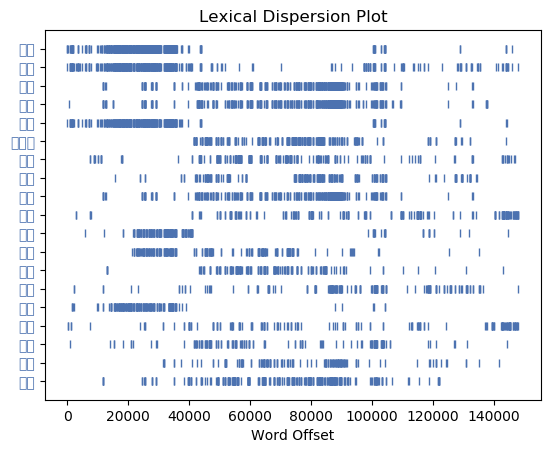

In [59]:
sns.reset_orig() 
aText.dispersion_plot([ 
 '女排',
 '世界',
 '条例',
 '逃犯',
 '联赛',
 '外交部',
 '警方',
 '事务',
 '修订',
 '警察',
 '冠军',
 '情况', 
 '暴力',
 '问题',
 '比赛',
 '市民',
 '记者',
 '社会',
 '修例'])
sns.set() 


## 4.2 Top Contributor Similarity Test 

In [60]:
#creating a database with only top 15 contributors

In [61]:
jun_topdf = jundf

In [62]:
jun_username = jun_topdf['name'].tolist()

jun_countedWords = wordCounter(jun_username)

In [65]:
jun_countedWords[:3]

,word,count
0,新浪排球,45
1,大公報-大公網,85
2,ruiren蕤人,1


In [66]:
jun_topdf = jun_topdf.sort_values(by=['top_contributor'], ascending=False)
jun_topdf=jun_topdf.reset_index(drop=True)

In [67]:
jun_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,06/20/19,环球时报,【王毅：坚决反对外部势力插手香港事务】2019年6月19日，国务委员兼外长王毅在北京同荷兰外...,149.0,1080.0,1229.0,"[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, 月...","[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, 月...","[[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, ...","[[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 年, 月, 日, 国务委...",1,"[[(王毅, NNP), (坚决, RB), (反对, VV), (外部, NN), (势力..."
1,06/16/19,香港文匯網,【父亲节心声活动 冀美国勿煽动孩子卷入政治漩涡】保公义撑修例大联盟、工联会约40名代表，今日...,18.0,117.0,135.0,"[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保,...","[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保,...","[[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保...","[[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保...",1,"[[(父亲节, NNP), (心声, NN), (活动, VV), (冀, NNP), (美..."
2,06/14/19,大公報-大公網,【中国外交部：妄想在香港制造混乱的图谋不会得逞】据报道，日前，美国国会议员重提“香港人权与民...,49.0,244.0,293.0,"[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, 报...","[中国外交部, 妄想, 香港, 制造, 混乱, 图谋, 不会, 得逞, 报道, 日前, 美国...","[[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, ...","[[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, ...",1,"[[(中国外交部, NNP), (妄想, NN), (在, VV), (香港, NNP), ..."


In [68]:
for i in range (len(jun_topdf)):
    if jun_topdf['top_contributor'][i] == 0:
        print (i)
        break 

295


In [69]:
jun_topdf = jun_topdf.drop(jun_topdf.index[295:])

In [70]:
jun_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,06/20/19,环球时报,【王毅：坚决反对外部势力插手香港事务】2019年6月19日，国务委员兼外长王毅在北京同荷兰外...,149.0,1080.0,1229.0,"[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, 月...","[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, 月...","[[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 2019, 年, 6, ...","[[王毅, 坚决, 反对, 外部, 势力, 插手, 香港, 事务, 年, 月, 日, 国务委...",1,"[[(王毅, NNP), (坚决, RB), (反对, VV), (外部, NN), (势力..."
1,06/16/19,香港文匯網,【父亲节心声活动 冀美国勿煽动孩子卷入政治漩涡】保公义撑修例大联盟、工联会约40名代表，今日...,18.0,117.0,135.0,"[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保,...","[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保,...","[[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保...","[[父亲节, 心声, 活动, 冀, 美国, 勿, 煽动, 孩子, 卷入, 政治, 漩涡, 保...",1,"[[(父亲节, NNP), (心声, NN), (活动, VV), (冀, NNP), (美..."
2,06/14/19,大公報-大公網,【中国外交部：妄想在香港制造混乱的图谋不会得逞】据报道，日前，美国国会议员重提“香港人权与民...,49.0,244.0,293.0,"[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, 报...","[中国外交部, 妄想, 香港, 制造, 混乱, 图谋, 不会, 得逞, 报道, 日前, 美国...","[[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, ...","[[中国外交部, 妄想, 在, 香港, 制造, 混乱, 的, 图谋, 不会, 得逞, 据, ...",1,"[[(中国外交部, NNP), (妄想, NN), (在, VV), (香港, NNP), ..."


In [71]:
jun_topdf = jun_topdf.sort_values(by=['name'], ascending=True)
jun_topdf=jun_topdf.reset_index(drop=True)

In [72]:
jun_topdf

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,06/23/19,上帝之鹰_5zn,年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围...,80.0,1542.0,1622.0,"[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法,...","[年, 已, 八旬, 白发苍苍, 前, 特区, 律政司, 司长, 香港特区, 基本法, 委员...","[[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法...","[[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法...",1,"[[(年, NN), (已, RB), (八旬, VV), (白发苍苍, NNP), (的,..."
1,06/24/19,上帝之鹰_5zn,原来700多万人日常所需的水和电，可以和进口食品一样，通过远洋运输解决……61万粉丝的大V，...,79.0,1870.0,1949.0,"[原来, 700, 多万, 人, 日常, 所, 需, 的, 水, 和, 电, 可以, 和, ...","[原来, 700, 多万, 人, 日常, 需, 水, 电, 进口, 食品, 远洋运输, 解决...","[[原来, 700, 多万, 人, 日常, 所, 需, 的, 水, 和, 电, 可以, 和,...","[[原来, 多万, 人, 日常, 所, 需, 的, 水, 和, 电, 可以, 和, 进口, ...",1,"[[(原来, RB), (多万, VV), (人, SFN), (日常, JJ), (所, ..."
2,06/21/19,上帝之鹰_5zn,网友来稿选登：东京羽田机场在介绍航模时，将香港和台湾列为“国家”。 ​,42.0,956.0,998.0,"[网友, 来稿, 选登, 东京, 羽田机场, 在, 介绍, 航模, 时, 将, 香港, 和,...","[网友, 来稿, 选登, 东京, 羽田机场, 介绍, 航模, 时, 香港, 台湾, 列为, ...","[[网友, 来稿, 选登, 东京, 羽田机场, 在, 介绍, 航模, 时, 将, 香港, 和...","[[网友, 来稿, 选登, 东京, 羽田机场, 在, 介绍, 航模, 时, 将, 香港, 和...",1,"[[(网友, NN), (来稿, VV), (选登, NNP), (东京, NNP), (羽..."
3,06/13/19,中国新闻网,【外交部：香港金钟一带发生的情况是公然地、有组织地发动暴动 支持香港特区政府依法处置】13日...,206.0,1204.0,1410.0,"[外交部, 香港, 金钟, 一带, 发生, 的, 情况, 是, 公然, 地, 有, 组织, ...","[外交部, 香港, 金钟, 一带, 发生, 情况, 公然, 组织, 发动, 暴动, 支持, ...","[[外交部, 香港, 金钟, 一带, 发生, 的, 情况, 是, 公然, 地, 有, 组织,...","[[外交部, 香港, 金钟, 一带, 发生, 的, 情况, 是, 公然, 地, 有, 组织,...",1,"[[(外交部, NN), (香港, NNP), (金钟, NNP), (一带, NN), (..."
4,06/13/19,中国新闻网,【香港金钟发生骚乱 《逃犯条例》修订草案审议被推迟】香港特区政府总部和立法会大楼所在的金钟地...,94.0,511.0,605.0,"[香港, 金钟, 发生, 骚乱, 逃犯, 条例, 修订, 草案, 审议, 被, 推迟, 香港...","[香港, 金钟, 发生, 骚乱, 逃犯, 条例, 修订, 草案, 审议, 推迟, 香港特区政...","[[香港, 金钟, 发生, 骚乱], [逃犯, 条例, 修订, 草案, 审议, 被, 推迟,...","[[香港, 金钟, 发生, 骚乱], [逃犯, 条例, 修订, 草案, 审议, 被, 推迟,...",1,"[[(香港, NNP), (金钟, NNP), (发生, VV), (骚乱, NN), (逃..."
...,...,...,...,...,...,...,...,...,...,...,...,...
290,06/25/19,香港自由行加加,香港人住宿的房子本身空间小，因此都要善用空间，但面对一些收纳认知等于零的人来说实在无语。#真...,60.0,290.0,350.0,"[香港, 人, 住宿, 的, 房子, 本身, 空间, 小, 因此, 都, 要, 善用, 空间...","[香港, 人, 住宿, 房子, 本身, 空间, 小, 都, 善用, 空间, 面对, 收纳, ...","[[香港, 人, 住宿, 的, 房子, 本身, 空间, 小, 因此, 都, 要, 善用, 空...","[[香港, 人, 住宿, 的, 房子, 本身, 空间, 小, 因此, 都, 要, 善用, 空...",1,"[[(香港, NNP), (人, SFN), (住宿, VV), (的, DEC), (房子..."
291,06/23/19,香港自由行加加,80年代初，航拍香港 #香港典故# #港澳风景摄影# ​,32.0,151.0,183.0,"[80, 年代, 初, 航拍, 香港, 香港, 典故, 港澳, 风景, 摄影, ​]","[80, 年代, 初, 航拍, 香港, 香港, 典故, 港澳, 风景, 摄影, ​]","[[80, 年代, 初, 航拍, 香港, 香港, 典故, 港澳, 风景, 摄影, ​]]","[[年代, 初, 航拍, 香港, 香港, 典故, 港澳, 风景, 摄影, ​]]",1,"[[(年代, NN), (初, IN), (航拍, VV), (香港, NNP), (香港,..."
292,06/20/19,香港自由行加加,实用面积42.7平米，价格1314万港币，位置在地铁站上面，香港的楼价实在。。。 #真实的香...,96.0,227.0,323.0,"[实用, 面积, 42.7, 平米, 价格, 1314, 万, 港币, 位置, 在, 地铁站...","[实用, 面积, 42.7, 平米, 价格, 1314, 万, 港币, 位置, 地铁站, 上...","[[实用, 面积, 42.7, 平米, 价格, 1314, 万, 港币, 位置, 在, 地铁...","[[实用, 面积, 平米, 价格, 万, 港币, 位置, 在, 地铁站, 上面, 香港, 的...",1,"[[(实用, NN), (面积, NN), (平米, NN), (价格, NN), (万, ..."
293,06/30/19,香港自由行加加,1946年的香港，第一个镜头就是半岛酒店 #香港典故# 1931年，香港人口约84万；193...,46.0,118.0,164.0,"[1946, 年, 的, 香港, 第一个, 镜头, 就是, 半岛, 酒店, 香港, 典故, ...","[1946, 年, 香港, 第一个, 镜头, 半岛, 酒店, 香港, 典故, 1931, 年...","[[1946, 年, 的, 香港, 第一个, 镜头, 就是, 半岛, 酒店, 香港, 典故,...","[[年, 的, 香港, 第一个, 镜头, 就是, 半岛, 酒店, 香港, 典故, 年, 香港...",1,"[[(年, NN), (的, DEC), (香港, NNP), (第一个, CD), (镜头..."


In [73]:
jun_username = jun_topdf['name'].tolist()
jun_countedWords = wordCounter(jun_username)
jun_countedWords

,word,count
0,上帝之鹰_5zn,3
1,中国新闻网,12
2,大公報-大公網,85
3,武力统一,8
4,环球时报,21
5,环球网,12
6,观察者网,26
7,香港商報網,48
8,香港文匯網,49
9,香港自由行加加,31


In [74]:
jun_topdf = jun_topdf.drop(columns=['date','retweets','like','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])


In [75]:
jun_topdf[:3]

,name,text,tokenized_sents,normalized_sents
0,上帝之鹰_5zn,年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围...,"[[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法...","[[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法..."
1,上帝之鹰_5zn,原来700多万人日常所需的水和电，可以和进口食品一样，通过远洋运输解决……61万粉丝的大V，...,"[[原来, 700, 多万, 人, 日常, 所, 需, 的, 水, 和, 电, 可以, 和,...","[[原来, 多万, 人, 日常, 所, 需, 的, 水, 和, 电, 可以, 和, 进口, ..."
2,上帝之鹰_5zn,网友来稿选登：东京羽田机场在介绍航模时，将香港和台湾列为“国家”。 ​,"[[网友, 来稿, 选登, 东京, 羽田机场, 在, 介绍, 航模, 时, 将, 香港, 和...","[[网友, 来稿, 选登, 东京, 羽田机场, 在, 介绍, 航模, 时, 将, 香港, 和..."


In [76]:
jun_topdf = jun_topdf.groupby(['name'], as_index = False).agg({'text': ''.join})

In [77]:
jun_topdf

,name,text
0,上帝之鹰_5zn,年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围...
1,中国新闻网,【外交部：香港金钟一带发生的情况是公然地、有组织地发动暴动 支持香港特区政府依法处置】13日...
2,大公報-大公網,【图集│驻港部队军营今派发月底开放券市民感雀跃】历年深受香港市民欢迎的解放军驻港部队军营开放...
3,武力统一,香港这样真英雄越多越好~看哪个分裂份子还敢张狂 武统号的秒拍视频 ​​​香港警察~我们挺你...
4,环球时报,【外交部回应香港游行:反对外部势力干涉特区立法事务】6月10日，外交部新闻发言人耿爽主持例行...
5,环球网,【港媒：#香港赠故宫140吨缴获走私檀木# 用于古建筑修缮等】在香港特区行政长官林郑月娥的见...
6,观察者网,香港警务处处长还原驱散暴徒经过，事件已定性为“暴乱”。香港警务处处长召开新闻发布会，强调警方...
7,香港商報網,【市民撑警严正执法 保护香港彰显正义】多个团体昨日联合举办「支持香港警察祝福香港晚会」。发起...
8,香港文匯網,【反对派瞎了吗？都来看看他们是不是“手无寸铁”的年轻人？】近日在香港发生的“金钟暴动”中，不...
9,香港自由行加加,下班了，对着夕阳喝一杯？#香港自由行# 店名：炊公馆，地址：铜锣湾谢斐道535号Tower ...


In [82]:
jun_topdf['text'][0]

'年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围攻，对方冲她大爆粗口：“死贱种”、“X你老母”，原因只有一个，她爱国。 \u200b原来700多万人日常所需的水和电，可以和进口食品一样，通过远洋运输解决……61万粉丝的大V，就这水平，我也是醉了。话说回来，既然香港真的不需要广东的水和电，那深圳干脆真的断供几个月如何？ \u200b网友来稿选登：东京羽田机场在介绍航模时，将香港和台湾列为“国家”。 \u200b'

In [83]:
#tokenize and normalize

In [84]:
#tokenize words
jun_topdf['tokenized_words'] = jun_topdf['text'].apply(lambda x: word_tokenize(x))

In [85]:
jun_topdf['normalized_words'] = jun_topdf['tokenized_words'].apply(lambda x: clean(x, stopwords_chi))


In [89]:
jun_topdf

,name,text,tokenized_words,normalized_words
0,上帝之鹰_5zn,年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围...,"[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法,...","[年, 已, 八旬, 白发苍苍, 前, 特区, 律政司, 司长, 香港特区, 基本法, 委员..."
1,中国新闻网,【外交部：香港金钟一带发生的情况是公然地、有组织地发动暴动 支持香港特区政府依法处置】13日...,"[外交部, 香港, 金钟, 一带, 发生, 的, 情况, 是, 公然, 地, 有, 组织, ...","[外交部, 香港, 金钟, 一带, 发生, 情况, 公然, 组织, 发动, 暴动, 支持, ..."
2,大公報-大公網,【图集│驻港部队军营今派发月底开放券市民感雀跃】历年深受香港市民欢迎的解放军驻港部队军营开放...,"[图集, │, 驻港部队, 军营, 今, 派发, 月底, 开放, 券, 市民, 感, 雀跃,...","[图集, │, 驻港部队, 军营, 今, 派发, 月底, 开放, 券, 市民, 感, 雀跃,..."
3,武力统一,香港这样真英雄越多越好~看哪个分裂份子还敢张狂 武统号的秒拍视频 ​​​香港警察~我们挺你...,"[香港, 这样, 真, 英雄, 越多越好, ~, 看, 哪个, 分裂, 份子, 还敢, 张狂...","[香港, 真, 英雄, 越多越好, ~, 看, 分裂, 份子, 还敢, 张狂, 武统, 号,..."
4,环球时报,【外交部回应香港游行:反对外部势力干涉特区立法事务】6月10日，外交部新闻发言人耿爽主持例行...,"[外交部, 回应, 香港, 游行, 反对, 外部, 势力, 干涉, 特区, 立法, 事务, ...","[外交部, 回应, 香港, 游行, 反对, 外部, 势力, 干涉, 特区, 立法, 事务, ..."
5,环球网,【港媒：#香港赠故宫140吨缴获走私檀木# 用于古建筑修缮等】在香港特区行政长官林郑月娥的见...,"[港媒, 香港, 赠, 故宫, 140, 吨, 缴获, 走私, 檀木, 用于, 古建筑, 修...","[港媒, 香港, 赠, 故宫, 140, 吨, 缴获, 走私, 檀木, 用于, 古建筑, 修..."
6,观察者网,香港警务处处长还原驱散暴徒经过，事件已定性为“暴乱”。香港警务处处长召开新闻发布会，强调警方...,"[香港, 警务处, 处长, 还原, 驱散, 暴徒, 经过, 事件, 已, 定性, 为, 暴乱...","[香港, 警务处, 处长, 还原, 驱散, 暴徒, 事件, 已, 定性, 暴乱, 香港, 警..."
7,香港商報網,【市民撑警严正执法 保护香港彰显正义】多个团体昨日联合举办「支持香港警察祝福香港晚会」。发起...,"[市民, 撑警, 严正, 执法, 保护, 香港, 彰显, 正义, 多个, 团体, 昨日, 联...","[市民, 撑警, 严正, 执法, 保护, 香港, 彰显, 正义, 多个, 团体, 昨日, 联..."
8,香港文匯網,【反对派瞎了吗？都来看看他们是不是“手无寸铁”的年轻人？】近日在香港发生的“金钟暴动”中，不...,"[反对派, 瞎, 了, 吗, 都, 来, 看看, 他们, 是不是, 手无寸铁, 的, 年轻人...","[反对派, 瞎, 都, 看看, 是不是, 手无寸铁, 年轻人, 近日, 香港, 发生, 金钟..."
9,香港自由行加加,下班了，对着夕阳喝一杯？#香港自由行# 店名：炊公馆，地址：铜锣湾谢斐道535号Tower ...,"[下班, 了, 对, 着, 夕阳, 喝一杯, 香港, 自由, 行, 店名, 炊, 公馆, 地...","[下班, 夕阳, 喝一杯, 香港, 自由, 行, 店名, 炊, 公馆, 地址, 铜锣湾, 谢..."


In [90]:
keywords = [ '女排',
 '世界',
 '条例',
 '逃犯',
 '联赛',
 '外交部',
 '警方',
 '事务',
 '修订',
 '警察',
 '冠军',
 '情况', '暴力',
 '问题',
 '比赛',
 '市民',
 '记者',
 '社会',
 '修例']

taggedDocs = []
for index, row in jun_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['name'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
jun_topdf['TaggedAbstracts'] = taggedDocs


In [91]:
jun_topdf

,name,text,tokenized_words,normalized_words,TaggedAbstracts
0,上帝之鹰_5zn,年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围...,"[年, 已, 八旬, 白发苍苍, 的, 前, 特区, 律政司, 司长, 香港特区, 基本法,...","[年, 已, 八旬, 白发苍苍, 前, 特区, 律政司, 司长, 香港特区, 基本法, 委员...","([年, 已, 八旬, 白发苍苍, 前, 特区, 律政司, 司长, 香港特区, 基本法, 委..."
1,中国新闻网,【外交部：香港金钟一带发生的情况是公然地、有组织地发动暴动 支持香港特区政府依法处置】13日...,"[外交部, 香港, 金钟, 一带, 发生, 的, 情况, 是, 公然, 地, 有, 组织, ...","[外交部, 香港, 金钟, 一带, 发生, 情况, 公然, 组织, 发动, 暴动, 支持, ...","([外交部, 香港, 金钟, 一带, 发生, 情况, 公然, 组织, 发动, 暴动, 支持,..."
2,大公報-大公網,【图集│驻港部队军营今派发月底开放券市民感雀跃】历年深受香港市民欢迎的解放军驻港部队军营开放...,"[图集, │, 驻港部队, 军营, 今, 派发, 月底, 开放, 券, 市民, 感, 雀跃,...","[图集, │, 驻港部队, 军营, 今, 派发, 月底, 开放, 券, 市民, 感, 雀跃,...","([图集, │, 驻港部队, 军营, 今, 派发, 月底, 开放, 券, 市民, 感, 雀跃..."
3,武力统一,香港这样真英雄越多越好~看哪个分裂份子还敢张狂 武统号的秒拍视频 ​​​香港警察~我们挺你...,"[香港, 这样, 真, 英雄, 越多越好, ~, 看, 哪个, 分裂, 份子, 还敢, 张狂...","[香港, 真, 英雄, 越多越好, ~, 看, 分裂, 份子, 还敢, 张狂, 武统, 号,...","([香港, 真, 英雄, 越多越好, ~, 看, 分裂, 份子, 还敢, 张狂, 武统, 号..."
4,环球时报,【外交部回应香港游行:反对外部势力干涉特区立法事务】6月10日，外交部新闻发言人耿爽主持例行...,"[外交部, 回应, 香港, 游行, 反对, 外部, 势力, 干涉, 特区, 立法, 事务, ...","[外交部, 回应, 香港, 游行, 反对, 外部, 势力, 干涉, 特区, 立法, 事务, ...","([外交部, 回应, 香港, 游行, 反对, 外部, 势力, 干涉, 特区, 立法, 事务,..."
5,环球网,【港媒：#香港赠故宫140吨缴获走私檀木# 用于古建筑修缮等】在香港特区行政长官林郑月娥的见...,"[港媒, 香港, 赠, 故宫, 140, 吨, 缴获, 走私, 檀木, 用于, 古建筑, 修...","[港媒, 香港, 赠, 故宫, 140, 吨, 缴获, 走私, 檀木, 用于, 古建筑, 修...","([港媒, 香港, 赠, 故宫, 140, 吨, 缴获, 走私, 檀木, 用于, 古建筑, ..."
6,观察者网,香港警务处处长还原驱散暴徒经过，事件已定性为“暴乱”。香港警务处处长召开新闻发布会，强调警方...,"[香港, 警务处, 处长, 还原, 驱散, 暴徒, 经过, 事件, 已, 定性, 为, 暴乱...","[香港, 警务处, 处长, 还原, 驱散, 暴徒, 事件, 已, 定性, 暴乱, 香港, 警...","([香港, 警务处, 处长, 还原, 驱散, 暴徒, 事件, 已, 定性, 暴乱, 香港, ..."
7,香港商報網,【市民撑警严正执法 保护香港彰显正义】多个团体昨日联合举办「支持香港警察祝福香港晚会」。发起...,"[市民, 撑警, 严正, 执法, 保护, 香港, 彰显, 正义, 多个, 团体, 昨日, 联...","[市民, 撑警, 严正, 执法, 保护, 香港, 彰显, 正义, 多个, 团体, 昨日, 联...","([市民, 撑警, 严正, 执法, 保护, 香港, 彰显, 正义, 多个, 团体, 昨日, ..."
8,香港文匯網,【反对派瞎了吗？都来看看他们是不是“手无寸铁”的年轻人？】近日在香港发生的“金钟暴动”中，不...,"[反对派, 瞎, 了, 吗, 都, 来, 看看, 他们, 是不是, 手无寸铁, 的, 年轻人...","[反对派, 瞎, 都, 看看, 是不是, 手无寸铁, 年轻人, 近日, 香港, 发生, 金钟...","([反对派, 瞎, 都, 看看, 是不是, 手无寸铁, 年轻人, 近日, 香港, 发生, 金..."
9,香港自由行加加,下班了，对着夕阳喝一杯？#香港自由行# 店名：炊公馆，地址：铜锣湾谢斐道535号Tower ...,"[下班, 了, 对, 着, 夕阳, 喝一杯, 香港, 自由, 行, 店名, 炊, 公馆, 地...","[下班, 夕阳, 喝一杯, 香港, 自由, 行, 店名, 炊, 公馆, 地址, 铜锣湾, 谢...","([下班, 夕阳, 喝一杯, 香港, 自由, 行, 店名, 炊, 公馆, 地址, 铜锣湾, ..."


In [93]:
jun_topdf['text'][0]

'年已八旬、白发苍苍的前特区律政司司长，香港特区基本法委员会副主任梁爱诗现身公共场合，遭暴民围攻，对方冲她大爆粗口：“死贱种”、“X你老母”，原因只有一个，她爱国。 \u200b原来700多万人日常所需的水和电，可以和进口食品一样，通过远洋运输解决……61万粉丝的大V，就这水平，我也是醉了。话说回来，既然香港真的不需要广东的水和电，那深圳干脆真的断供几个月如何？ \u200b网友来稿选登：东京羽田机场在介绍航模时，将香港和台湾列为“国家”。 \u200b'

In [94]:
topD2V = gensim.models.doc2vec.Doc2Vec(jun_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [95]:
topD2V.docvecs[10]


array([-0.10933049, -0.2111574 , -0.01664878,  0.13256027,  0.12690704,
       -0.16313629, -0.06918298,  0.4433057 ,  0.10721511,  0.3137551 ,
       -0.04607054, -0.28756472, -0.00636928,  0.3422514 , -0.2621959 ,
       -0.6634573 ,  0.3524384 , -0.11272487, -0.31519884,  0.07474058,
        0.20742936,  0.00277903,  0.06876153, -0.18138097, -0.18863173,
       -0.03381931,  0.17965357,  0.36255607, -0.17670879, -0.00908614,
        0.7327765 ,  0.2878782 , -0.12593251,  0.27874547,  0.309707  ,
        0.02898985,  0.0076021 , -0.12170272, -0.35731518,  0.47452128,
        0.13555577,  0.14246176,  0.08627065, -0.34494132, -0.05890993,
        0.62734395,  0.06555703,  0.14586188, -0.60727185, -0.01779451,
        0.23500341,  0.3334585 ,  0.3302123 ,  0.20176977,  0.01858189,
        0.6669509 ,  0.35355616, -0.41899028, -0.14877258,  0.06390998,
       -0.05131037, -0.10707301, -0.13258846, -0.27921286,  0.14643952,
       -0.35852128,  0.3136614 , -0.40844625,  0.19920252,  0.27

In [96]:
targetDocs = jun_topdf['name']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

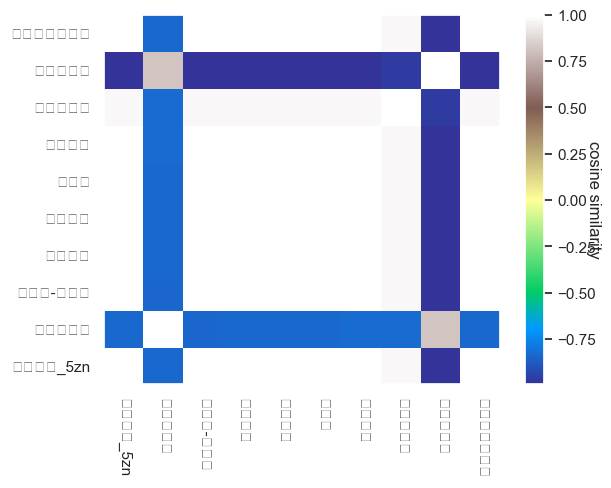

In [99]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [256]:
jun_topdf['text'][7]

'【市民撑警严正执法 保护香港彰显正义】多个团体昨日联合举办「支持香港警察祝福香港晚会」。发起集会的正义联盟主席李偲嫣表示，警方一直在保护家园，但最近一直被侮辱、「起底」，希望通过这次集会表达市民对警察的支持。多名参与晚会的市民均表示，看到不少示威者在捣乱香港，支持香港警察严正执法 \u200b  展开全文【周庭被DQ提呈请 选举主任代表律师：主张「民主自决」违反基本法】「香港众志」成员周庭就去年初被褫夺参加立法会港岛区补选的资格，提出选举呈请，案件今日在高院审讯。代表选举主任的律师陈词称，拥护《基本法》和效忠香港特区是立法会选举候选人的先决条件，但「香港众志」主张的「民主自决」理念 \u200b  展开全文【东亚银行发警告：房企贷款"失血" 最高达30亿港元！】据券商中国报道，近日，香港本土老牌银行东亚银行发出警告，因为市场环境恶化，内地早年批出的贷款资产信贷评级下调，预计来自中国内地非一线城市商业地产资产减值损失25亿-30亿港元。记者注意到，房地产领域资产减值损失约占东亚银行去年同期上半 \u200b  展开全文【香港电影，又走了一个“恶人”】综合本港多个消息来源，在香港有“影坛四大恶人之一”称号的香港知名演员李兆基6月2日因肝癌扩散至肺部去世，终年69岁。李兆基在其参演的香港电影中曾多次扮演“江湖人物”，曾参演《古惑仔》《纵横四海》《食神》《扫毒》等电影。因在《古惑仔》系列电影饰演“吹水 \u200b  展开全文,【香港电影，又走了一个“恶人”】综合本港多个消息来源，在香港有“影坛四大恶人之一”称号的香港知名演员李兆基6月2日因肝癌扩散至肺部去世，终年69岁。李兆基在其参演的香港电影中曾多次扮演“江湖人物”，曾参演《古惑仔》《纵横四海》《食神》《扫毒》等电影。因在《古惑仔》系列电影饰演“吹水基”而被称为“基哥”。由于专演“恶人”，李兆基与何家驹、成奎安、黄光亮等演员被并称为“影坛四大恶人”。李兆基去年确诊患上肝癌，媒体此前报道称，他曾一度有放弃治疗的打算，但近日在亲友鼓励之下最后成功切除肝脏肿瘤，当时康复进度理想，已回家休养。不过，多家港媒2日报道称，李兆基不敌“癌魔”，因肝癌扩散到肺部而去世，终年69岁。 收起全文【李小加：做不好一国两制 香港里外不是人】商界人士均认为一国两制是香港的优势所在，一定要全力维持，港交所总裁李小加指出，香港人必须要有充份的智慧

## 4.3 Semantic Influence Networks based on noun-verb pairs
to see check if they are using the same noun-verb pairs


In [101]:
jun_topdf['tokenized_sents'] = jun_topdf['text'].apply(lambda x: [word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
jun_topdf['normalized_sents'] = jun_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [102]:
g = posCooccurrence(jun_topdf['normalized_sents'].sum(), 'NN', 'VV')

In [103]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [104]:
len(g.nodes)

648

In [105]:
len(g.edges)

0

In [106]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [107]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(jun_topdf['text'])


In [108]:
tweetVects_incidence.shape


(10, 795)

In [109]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [110]:
print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 805
Number of edges: 823
Average degree:   2.0447


In [111]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 10
Number of edges: 45
Average degree:   9.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


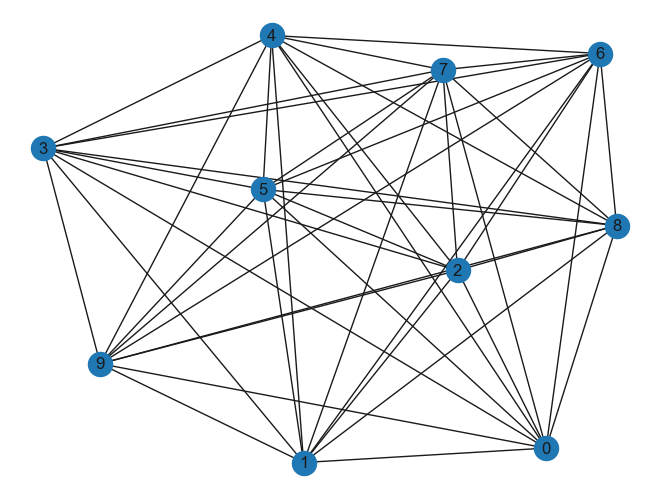

In [112]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

# 5. July Analysis

## 5.1 Word Count & Distribution to build Narrative

In [113]:
juldf['POS_sents'] = juldf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
juldf['POS_sents']

1882    [[(香港回归, NNP), (周年, NN), (珍贵, JJ), (历史, NN), (...
1883    [[(亿港元, NNP), (保费, VV), (一夜, JJ), (亏空, NN), (为...
1884    [[(年, NN), (香港回归, NNP), (霸气, NN), (时刻, NN), (我...
1885    [[(香港市民, NNP), (发起, VV), (集会, NN), (支持, VV), (...
1886    [[(香港, NNP), (的, DEC), (事情, NN), (令人担忧, RB), (...
                              ...                        
6539    [[(法庭, NN), (见, VV), (香港, NNP), (激进, JJ), (示威者...
6540    [[(台风, NN), (韦帕, NNP), (香港, NNP), (天文台, NN), (...
6541    [[(地球, NNP), (透支, VV), (日, CD), (月, NNB), (出现,...
6542    [[(如果, IN), (挺身而出, VV), (的, DEC), (市民, NN), (多...
6543    [[(新西兰, NNP), (奥克兰, NNP), (大学, NN), (列侬, NNP),...
Name: POS_sents, Length: 4662, dtype: object

In [115]:
countTarget = 'NN'
targetCounts = {}
for entry in juldf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1

In [125]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [126]:
sortedTargets[:30]

[('全文', 2373),
 ('视频', 1590),
 ('警方', 1285),
 ('暴力', 1058),
 ('\u200b', 1044),
 ('示威者', 806),
 ('警察', 781),
 ('微博', 743),
 ('人', 733),
 ('网页', 649),
 ('等', 511),
 ('事件', 459),
 ('链接', 450),
 ('法治', 406),
 ('暴徒', 387),
 ('市民', 380),
 ('部分', 380),
 ('老人', 378),
 ('秒', 375),
 ('今天', 356),
 ('集会', 352),
 ('社会', 350),
 ('事务', 335),
 ('现场', 333),
 ('问题', 324),
 ('记者', 324),
 ('国家', 312),
 ('大楼', 308),
 ('外交部', 304),
 ('今日', 302)]

In [127]:
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [130]:
nntoken[:40]

['全文',
 '视频',
 '警方',
 '暴力',
 '\\u200b',
 '示威者',
 '警察',
 '微博',
 '人',
 '网页',
 '等',
 '事件',
 '链接',
 '法治',
 '暴徒',
 '市民',
 '部分',
 '老人',
 '秒',
 '今天',
 '集会',
 '社会',
 '事务',
 '现场',
 '问题',
 '记者',
 '国家',
 '大楼',
 '外交部',
 '今日',
 '新闻',
 '国际',
 '男子',
 '机场',
 '下午',
 '言论',
 '势力',
 '内地',
 '活动',
 '大陆']

In [131]:
#check the context of the word

In [277]:
import nltk
import seaborn as sns #makes our plots look nicer
all_words = juldf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)
#token = clean(token, stopwords_chi)

In [278]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 

In [279]:
aIndex.print_concordance('警察',lines = 1500)

Displaying 781 of 781 matches:
 市民 在 金钟 添马 公园 参与 撑 警队 护法 治 保 安宁 集会 支持 警察 执法 大会 公布 有 16.5 万人 参加 集会 很多 团体 和 个人 从 
持 警方 的 标语 高呼 撑 警队 护法 治 保 安宁 口号 表达 对 香港 警察 ​ 展开 全文 撑 警队 护法 治 保 安宁 香港市民 发起 集会 支持 警
 市民 在 金钟 添马 公园 参与 撑 警队 护法 治 保 安宁 集会 支持 警察 执法 大会 公布 有 16.5 万人 参加 集会 很多 团体 和 个人 从 
持 警方 的 标语 高呼 撑 警队 护法 治 保 安宁 口号 表达 对 香港 警察 的 支持 并 批评 早前 包围 警察 总部 的 示威者 要求 将 暴力 冲击
法 治 保 安宁 口号 表达 对 香港 警察 的 支持 并 批评 早前 包围 警察 总部 的 示威者 要求 将 暴力 冲击 者 绳之以法 香港市民 发起 集会 
 视频 ​ 16 万港民 集会 支持 港警 除暴安良 谭咏麟 带头 高喊 撑 警察 据港媒 报道 6 月 30 日 近 17 万 香港市民 冒雨 走上 街头 参
 市民 在 金钟 添马 公园 参与 撑 警队 护法 治 保 安宁 集会 支持 警察 执法 大会 公布 有 16.5 万人 参加 集会 很多 团体 和 个人 从 
持 警方 的 标语 高呼 撑 警队 护法 治 保 安宁 口号 表达 对 香港 警察 ​ 展开 全文 撑 警队 护法 治 保 安宁 香港市民 发起 集会 支持 警
 市民 在 金钟 添马 公园 参与 撑 警队 护法 治 保 安宁 集会 支持 警察 执法 大会 公布 有 16.5 万人 参加 集会 很多 团体 和 个人 从 
持 警方 的 标语 高呼 撑 警队 护法 治 保 安宁 口号 表达 对 香港 警察 的 支持 并 批评 早前 包围 警察 总部 的 示威者 要求 将 暴力 冲击
法 治 保 安宁 口号 表达 对 香港 警察 的 支持 并 批评 早前 包围 警察 总部 的 示威者 要求 将 暴力 冲击 者 绳之以法 这 视频 这 视频 的
出来 30 日 下午 近 17 万 市民 冒雨 出席 撑警 集会 支持 香港 警察 维持秩序 他们 高呼口号 表达 ​ 展开 全文 香港市民 发起 集会 支

In [271]:
aText.common_contexts(['暴徒'])

全文_强 乱港_昨早 但_下午 社会治安_强 面对_疯狂 被_冲击 有_想 部分_冲击 花_找错 对_冲击 的_行径 显露出_的 允许_文化
全文_乱港 乱港_无法无天 受伤_午後变 受伤_午 全文_在 罪恶_在 警察_们


In [124]:
#check the distribution of the word

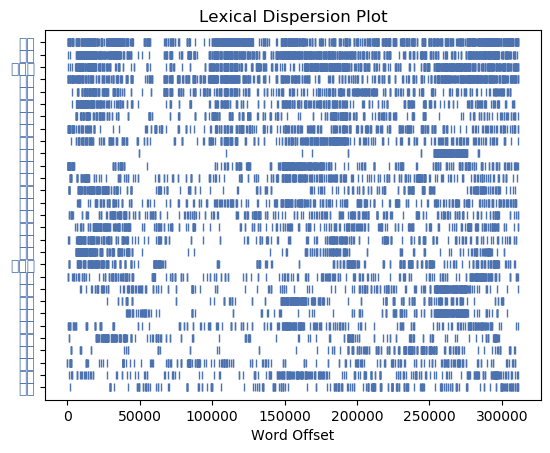

In [138]:
sns.reset_orig() 
aText.dispersion_plot([
 '警方',
 '暴力',
 '示威者',
 '警察',
 '事件',
 '法治',
 '暴徒',
 '市民',
 '部分',
 '老人',
 '集会',
 '社会',
 '事务',
 '现场',
 '问题',
 '记者',
 '国家',
 '大楼',
 '外交部',
 '新闻',
 '国际',
 '男子',
 '机场',
 '下午',
 '言论',
 '势力',
 '内地',
 '活动',
 '大陆'])
sns.set() 1


## 5.2 Top Contributor Similarity Test

In [139]:
#creating a database with only top 15 contributors

In [140]:
jul_topdf = juldf

In [141]:
jul_username = jul_topdf['name'].tolist()

jul_countedWords = wordCounter(jul_username)

In [142]:
jul_countedWords[:3]

,word,count
0,长兴新闻网,1
1,南方周末,3
2,1980s-2010s,1


In [143]:
jul_topdf = jul_topdf.sort_values(by=['top_contributor'], ascending=False)
jul_topdf=jul_topdf.reset_index(drop=True)

In [144]:
jul_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,07/24/19,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​,95.0,4082.0,4177.0,"[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]","[说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]",1,"[[(他们, PRP), (说, VV), (香港, NNP), (是, VC), (亚洲,..."
1,07/29/19,武力统一,深圳灣面朝香港🇨🇳紅旗飄飄 武力统一的秒拍视频 ​,33.0,219.0,252.0,"[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒, ...","[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 秒, 拍, ​]","[[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒,...","[[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒,...",1,"[[(深圳, NNP), (灣, SFN), (面朝, NN), (香港, NNP), (🇨..."
2,07/29/19,环球时报,【28日晚香港非法集会暴力升级，非法示威者多处纵火】晚20:30分左右，警方发表声明指示威者...,1205.0,14281.0,15486.0,"[28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火, ...","[28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火, ...","[[], [28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处,...","[[], [日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火,...",1,"[[( , _SP), (日晚, NN), (香港, NNP), (非法, JJ), (集会..."


In [145]:
for i in range (len(jul_topdf)):
    if jul_topdf['top_contributor'][i] == 0:
        print (i)
        break 

756


In [146]:
jul_topdf = jul_topdf.drop(jul_topdf.index[295:])

In [147]:
jul_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,07/24/19,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​,95.0,4082.0,4177.0,"[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]","[说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]",1,"[[(他们, PRP), (说, VV), (香港, NNP), (是, VC), (亚洲,..."
1,07/29/19,武力统一,深圳灣面朝香港🇨🇳紅旗飄飄 武力统一的秒拍视频 ​,33.0,219.0,252.0,"[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒, ...","[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 秒, 拍, ​]","[[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒,...","[[深圳, 灣, 面朝, 香港, 🇨, 🇳, 紅旗, 飄, 飄, 武力, 统一, 的, 秒,...",1,"[[(深圳, NNP), (灣, SFN), (面朝, NN), (香港, NNP), (🇨..."
2,07/29/19,环球时报,【28日晚香港非法集会暴力升级，非法示威者多处纵火】晚20:30分左右，警方发表声明指示威者...,1205.0,14281.0,15486.0,"[28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火, ...","[28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火, ...","[[], [28, 日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处,...","[[], [日晚, 香港, 非法, 集会, 暴力, 升级, 非法, 示威者, 多处, 纵火,...",1,"[[( , _SP), (日晚, NN), (香港, NNP), (非法, JJ), (集会..."


In [148]:
jul_topdf = jul_topdf.sort_values(by=['name'], ascending=True)
jul_topdf=jul_topdf.reset_index(drop=True)

In [149]:
jul_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,07/24/19,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​,95.0,4082.0,4177.0,"[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]","[说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]",1,"[[(他们, PRP), (说, VV), (香港, NNP), (是, VC), (亚洲,..."
1,07/08/19,上帝之鹰_5zn,这几天不断有人私信来问：近期去香港是否安全。在询问了多位人在香港的朋友后，我的回答是：没有问...,220.0,8787.0,9007.0,"[这, 几天, 不断, 有人, 私信, 来, 问, 近期, 去, 香港, 是否, 安全, 在...","[几天, 不断, 有人, 私信, 问, 近期, 去, 香港, 是否, 安全, 询问, 多位,...","[[这, 几天, 不断, 有人, 私信, 来, 问, 近期, 去, 香港, 是否, 安全, ...","[[这, 几天, 不断, 有人, 私信, 来, 问, 近期, 去, 香港, 是否, 安全, ...",1,"[[(这, DT), (几天, NN), (不断, RB), (有人, VV), (私信, ..."
2,07/09/19,上帝之鹰_5zn,每日一乐：黄尸废青和支持香港zf的父母因“政见不合”起了冲突。父母骂道：“有种搬出去住”。黄...,225.0,3638.0,3863.0,"[每日, 一, 乐, 黄尸, 废青, 和, 支持, 香港, zf, 的, 父母, 因, 政见...","[每日, 乐, 黄尸, 废青, 支持, 香港, zf, 父母, 政见, 不合, 冲突, 父母...","[[每日, 一, 乐, 黄尸, 废青, 和, 支持, 香港, zf, 的, 父母, 因, 政...","[[每日, 一, 乐, 黄尸, 废青, 和, 支持, 香港, zf, 的, 父母, 因, 政...",1,"[[(每日, DT), (一, CD), (乐, NNB), (黄尸, NNP), (废青,..."


In [150]:
jul_username = jul_topdf['name'].tolist()
jul_countedWords = wordCounter(jul_username)
jul_countedWords

,word,count
0,上帝之鹰_5zn,10
1,中国新闻网,14
2,大公報-大公網,48
3,帝吧官微,5
4,武力统一,6
5,热门表哥,4
6,环球时报,34
7,环球网,43
8,观察者网,30
9,香港商報網,30


In [151]:
jul_topdf = jul_topdf.drop(columns=['date','retweets','like','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])


In [152]:
jul_topdf[:3]

,name,text,tokenized_sents,normalized_sents
0,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​,"[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]","[[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​]]"
1,上帝之鹰_5zn,这几天不断有人私信来问：近期去香港是否安全。在询问了多位人在香港的朋友后，我的回答是：没有问...,"[[这, 几天, 不断, 有人, 私信, 来, 问, 近期, 去, 香港, 是否, 安全, ...","[[这, 几天, 不断, 有人, 私信, 来, 问, 近期, 去, 香港, 是否, 安全, ..."
2,上帝之鹰_5zn,每日一乐：黄尸废青和支持香港zf的父母因“政见不合”起了冲突。父母骂道：“有种搬出去住”。黄...,"[[每日, 一, 乐, 黄尸, 废青, 和, 支持, 香港, zf, 的, 父母, 因, 政...","[[每日, 一, 乐, 黄尸, 废青, 和, 支持, 香港, zf, 的, 父母, 因, 政..."


In [153]:
jul_topdf = jul_topdf.groupby(['name'], as_index = False).agg({'text': ''.join})

In [154]:
jul_topdf

,name,text
0,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​这几天不断有人私信来问：近期去香港...
1,中国新闻网,【国务院港澳办发言人：一国两制“三条底线”不能触碰】“一国两制”是一个完整的概念，是一套完整...
2,大公報-大公網,【议员并非特权阶级 教唆暴行应予检控】每逢冲击，乱港派议员必然落场。昨日民主党胡志伟、许智峯...
3,帝吧官微,老天爷要其灭亡，必先使其丧心病狂，最后的死硬分子，开始歇斯底里的疯狂，殊不知自己离中联办，已...
4,武力统一,香港民众开始清扫垃圾~ 微博视频 ​​​很多香港百姓是清醒的~ 微博视频 ​​​【視頻|香...
5,热门表哥,【香港政府和警察应该学学，北美崔哥采访美国警察是如何对付示威者的】 采访地点：纽约。...
6,环球时报,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...
7,环球网,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...
8,观察者网,【美政府给中企亮了“绿灯”：大疆无人机在美获安全许可】“在近来充斥怀疑和管制的环境下，这是中...
9,香港商報網,【新华时评：齐心反暴力 共同护香港】20日下午，香港各界人士发起“守护香港”大型集会，呼吁维...


In [155]:
#tokenize and normalize

In [156]:
#tokenize words
jul_topdf['tokenized_words'] = jul_topdf['text'].apply(lambda x: word_tokenize(x))

In [157]:
jul_topdf['normalized_words'] = jul_topdf['tokenized_words'].apply(lambda x: clean(x, stopwords_chi))


In [158]:
jul_topdf

,name,text,tokenized_words,normalized_words
0,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​这几天不断有人私信来问：近期去香港...,"[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​, 这, 几天,...","[说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​, 几天, 不断, 有人, 私信, ..."
1,中国新闻网,【国务院港澳办发言人：一国两制“三条底线”不能触碰】“一国两制”是一个完整的概念，是一套完整...,"[国务院, 港澳办, 发言人, 一国两制, 三条, 底线, 不能, 触碰, 一国两制, 是,...","[国务院, 港澳办, 发言人, 一国两制, 三条, 底线, 不能, 触碰, 一国两制, 完整..."
2,大公報-大公網,【议员并非特权阶级 教唆暴行应予检控】每逢冲击，乱港派议员必然落场。昨日民主党胡志伟、许智峯...,"[议员, 并非, 特权阶级, 教唆, 暴行, 应予, 检控, 每逢, 冲击, 乱港, 派, ...","[议员, 并非, 特权阶级, 教唆, 暴行, 应予, 检控, 每逢, 冲击, 乱港, 派, ..."
3,帝吧官微,老天爷要其灭亡，必先使其丧心病狂，最后的死硬分子，开始歇斯底里的疯狂，殊不知自己离中联办，已...,"[老天爷, 要, 其, 灭亡, 必先, 使, 其, 丧心病狂, 最后, 的, 死硬, 分子,...","[老天爷, 灭亡, 必先, 使, 丧心病狂, 最后, 死硬, 分子, 歇斯底里, 疯狂, 殊..."
4,武力统一,香港民众开始清扫垃圾~ 微博视频 ​​​很多香港百姓是清醒的~ 微博视频 ​​​【視頻|香...,"[香港, 民众, 开始, 清扫, 垃圾, ~, 微博, 视频, ​, ​, ​, 很多, 香...","[香港, 民众, 清扫, 垃圾, ~, ​, ​, ​, 很多, 香港, 百姓, 清醒, ~..."
5,热门表哥,【香港政府和警察应该学学，北美崔哥采访美国警察是如何对付示威者的】 采访地点：纽约。...,"[香港政府, 和, 警察, 应该, 学学, 北美, 崔哥, 采访, 美国, 警察, 是, 如...","[香港政府, 警察, 应该, 学学, 北美, 崔哥, 采访, 美国, 警察, 对付, 示威者..."
6,环球时报,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...,"[国务院, 港澳办, 发言人, 杨光, 向, 一直, 坚守岗位, 恪尽职守, 无惧, 无畏,...","[国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重, ..."
7,环球网,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...,"[国务院, 港澳办, 发言人, 杨光, 向, 一直, 坚守岗位, 恪尽职守, 无惧, 无畏,...","[国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重, ..."
8,观察者网,【美政府给中企亮了“绿灯”：大疆无人机在美获安全许可】“在近来充斥怀疑和管制的环境下，这是中...,"[美政府, 给, 中企, 亮, 了, 绿灯, 大疆, 无人机, 在, 美获, 安全, 许可,...","[美政府, 中企, 亮, 绿灯, 大疆, 无人机, 美获, 安全, 许可, 近来, 充斥, ..."
9,香港商報網,【新华时评：齐心反暴力 共同护香港】20日下午，香港各界人士发起“守护香港”大型集会，呼吁维...,"[新华, 时评, 齐心, 反, 暴力, 共同, 护, 香港, 20, 日, 下午, 香港, ...","[新华, 时评, 齐心, 反, 暴力, 共同, 护, 香港, 20, 日, 下午, 香港, ..."


In [161]:
keywords = [ '警方',
 '暴力',
 '示威者',
 '警察',
 '事件',
 '法治',
 '暴徒',
 '市民',
 '部分',
 '老人',
 '集会',
 '社会',
 '事务',
 '现场',
 '问题',
 '记者',
 '国家',
 '大楼',
 '外交部',
 '新闻',
 '国际',
 '男子',
 '机场',
 '下午',
 '言论',
 '势力',
 '内地',
 '活动',
 '大陆']

taggedDocs = []
for index, row in jul_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['name'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))

In [162]:
jul_topdf['TaggedAbstracts'] = taggedDocs


In [163]:
jul_topdf

,name,text,tokenized_words,normalized_words,TaggedAbstracts
0,上帝之鹰_5zn,“他们说，香港是亚洲最安全的城市”——————《寒战》 ​这几天不断有人私信来问：近期去香港...,"[他们, 说, 香港, 是, 亚洲, 最, 安全, 的, 城市, 寒战, ​, 这, 几天,...","[说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​, 几天, 不断, 有人, 私信, ...","([说, 香港, 亚洲, 最, 安全, 城市, 寒战, ​, 几天, 不断, 有人, 私信,..."
1,中国新闻网,【国务院港澳办发言人：一国两制“三条底线”不能触碰】“一国两制”是一个完整的概念，是一套完整...,"[国务院, 港澳办, 发言人, 一国两制, 三条, 底线, 不能, 触碰, 一国两制, 是,...","[国务院, 港澳办, 发言人, 一国两制, 三条, 底线, 不能, 触碰, 一国两制, 完整...","([国务院, 港澳办, 发言人, 一国两制, 三条, 底线, 不能, 触碰, 一国两制, 完..."
2,大公報-大公網,【议员并非特权阶级 教唆暴行应予检控】每逢冲击，乱港派议员必然落场。昨日民主党胡志伟、许智峯...,"[议员, 并非, 特权阶级, 教唆, 暴行, 应予, 检控, 每逢, 冲击, 乱港, 派, ...","[议员, 并非, 特权阶级, 教唆, 暴行, 应予, 检控, 每逢, 冲击, 乱港, 派, ...","([议员, 并非, 特权阶级, 教唆, 暴行, 应予, 检控, 每逢, 冲击, 乱港, 派,..."
3,帝吧官微,老天爷要其灭亡，必先使其丧心病狂，最后的死硬分子，开始歇斯底里的疯狂，殊不知自己离中联办，已...,"[老天爷, 要, 其, 灭亡, 必先, 使, 其, 丧心病狂, 最后, 的, 死硬, 分子,...","[老天爷, 灭亡, 必先, 使, 丧心病狂, 最后, 死硬, 分子, 歇斯底里, 疯狂, 殊...","([老天爷, 灭亡, 必先, 使, 丧心病狂, 最后, 死硬, 分子, 歇斯底里, 疯狂, ..."
4,武力统一,香港民众开始清扫垃圾~ 微博视频 ​​​很多香港百姓是清醒的~ 微博视频 ​​​【視頻|香...,"[香港, 民众, 开始, 清扫, 垃圾, ~, 微博, 视频, ​, ​, ​, 很多, 香...","[香港, 民众, 清扫, 垃圾, ~, ​, ​, ​, 很多, 香港, 百姓, 清醒, ~...","([香港, 民众, 清扫, 垃圾, ~, ​, ​, ​, 很多, 香港, 百姓, 清醒, ..."
5,热门表哥,【香港政府和警察应该学学，北美崔哥采访美国警察是如何对付示威者的】 采访地点：纽约。...,"[香港政府, 和, 警察, 应该, 学学, 北美, 崔哥, 采访, 美国, 警察, 是, 如...","[香港政府, 警察, 应该, 学学, 北美, 崔哥, 采访, 美国, 警察, 对付, 示威者...","([香港政府, 警察, 应该, 学学, 北美, 崔哥, 采访, 美国, 警察, 对付, 示威..."
6,环球时报,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...,"[国务院, 港澳办, 发言人, 杨光, 向, 一直, 坚守岗位, 恪尽职守, 无惧, 无畏,...","[国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重, ...","([国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重,..."
7,环球网,【国务院港澳办发言人杨光：向一直坚守岗位、恪尽职守、无惧无畏、忍辱负重的优秀香港警察，致以崇...,"[国务院, 港澳办, 发言人, 杨光, 向, 一直, 坚守岗位, 恪尽职守, 无惧, 无畏,...","[国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重, ...","([国务院, 港澳办, 发言人, 杨光, 坚守岗位, 恪尽职守, 无惧, 无畏, 忍辱负重,..."
8,观察者网,【美政府给中企亮了“绿灯”：大疆无人机在美获安全许可】“在近来充斥怀疑和管制的环境下，这是中...,"[美政府, 给, 中企, 亮, 了, 绿灯, 大疆, 无人机, 在, 美获, 安全, 许可,...","[美政府, 中企, 亮, 绿灯, 大疆, 无人机, 美获, 安全, 许可, 近来, 充斥, ...","([美政府, 中企, 亮, 绿灯, 大疆, 无人机, 美获, 安全, 许可, 近来, 充斥,..."
9,香港商報網,【新华时评：齐心反暴力 共同护香港】20日下午，香港各界人士发起“守护香港”大型集会，呼吁维...,"[新华, 时评, 齐心, 反, 暴力, 共同, 护, 香港, 20, 日, 下午, 香港, ...","[新华, 时评, 齐心, 反, 暴力, 共同, 护, 香港, 20, 日, 下午, 香港, ...","([新华, 时评, 齐心, 反, 暴力, 共同, 护, 香港, 20, 日, 下午, 香港,..."


In [308]:
jul_topdf['text'][8]

'【美政府给中企亮了“绿灯”：大疆无人机在美获安全许可】“在近来充斥怀疑和管制的环境下，这是中国科技企业获得美国政府批准的罕见例子”——香港《南华早报》10日报道称，经过对中国无人机制造商大疆创新的“政企版”无人机系统长达15个月的严格评估，美国内政部肯定其符合技术与风险要求，没有数据 \u200b  展开全文,【美政府给中企亮了“绿灯”：大疆无人机在美获安全许可】“在近来充斥怀疑和管制的环境下，这是中国科技企业获得美国政府批准的罕见例子”——香港《南华早报》10日报道称，经过对中国无人机制造商大疆创新的“政企版”无人机系统长达15个月的严格评估，美国内政部肯定其符合技术与风险要求，没有数据外泄的风险，同意在内部使用。大疆创新10日向《环球时报》记者证实了这一消息。美国内政部还表示，经过他们的市场研究，美国国内目前还没有可用的替代品，无论是价格、性能、可靠性及拓展性方面，其他产品都不及大疆无人机具有竞争力。 （环球网）美政府给中企亮了“绿灯”：大疆无人机在美获安全许可 收起全文香港某艺人叫嚣要将中国从联合国人权理事会除名，耿爽差点没憋住 外交部发言人办公室的微博视频 \u200b【美国多位高官排队会见香港商人黎智英，驻港公署严正交涉】外交部驻港公署网站7月9日消息，有媒体报道，美国副总统彭斯、国务卿蓬佩奥等日前分别会见了香港商人黎智英，讨论修订《逃犯条例》事态发展以及香港在“一国两制”下的自治地位。对此，外交公署发言人严正表示，坚决反对外部势力插手香港事务 \u200b  展开全文,【美国多位高官排队会见香港商人黎智英，驻港公署严正交涉】外交部驻港公署网站7月9日消息，有媒体报道，美国副总统彭斯、国务卿蓬佩奥等日前分别会见了香港商人黎智英，讨论修订《逃犯条例》事态发展以及香港在“一国两制”下的自治地位。对此，外交公署发言人严正表示，坚决反对外部势力插手香港事务，绝不会坐视国家主权安全和香港繁荣稳定受到损害。内外势力相互勾结、祸港殃民注定没有好下场。\u3000\u3000该发言人表示，黎智英是什么人、一贯持什么立场、在香港社会扮演着什么样的角色，美方心知肚明。美政府高层在当前香港局势的敏感时期，排着队会见这么一个人，别有用心，发出严重错误信号，我们对此表达强烈不满和坚决反对。彭斯、蓬佩奥见黎智英，驻港公署：内外势力勾结祸港注定没有好下场 收起全文【香港司机遭示威者围

In [165]:
topD2V = gensim.models.doc2vec.Doc2Vec(jul_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [166]:
topD2V.docvecs[10]


array([-2.04566896e-01, -1.61683649e-01,  1.89345360e-01,  5.95943093e-01,
       -3.63429897e-02,  6.42960984e-03, -2.18778461e-01,  4.76855755e-01,
       -2.71106005e-01,  7.27337658e-01, -1.03230096e-01,  1.13378368e-01,
       -1.21628225e-01,  6.11214221e-01, -5.00601470e-01, -5.75770885e-02,
        1.40729263e-01,  5.82647741e-01, -2.56840080e-01,  3.65042537e-01,
        2.18629912e-01, -2.02746272e-01,  1.63906977e-01, -9.18201327e-01,
       -3.57458681e-01, -3.63525897e-01,  2.73181945e-01,  4.10130531e-01,
        1.10206306e-01, -1.87305123e-01,  3.53915215e-01,  4.07135397e-01,
        3.37360173e-01, -1.62874892e-01,  6.93722725e-01, -1.58531189e-01,
        2.70034254e-01, -5.64216316e-01, -4.98929590e-01,  2.59269506e-01,
       -6.44545019e-01, -4.87917423e-01, -1.37588605e-01, -8.38083506e-01,
       -1.41619861e-01, -8.99205334e-04,  6.93194091e-01,  3.94577503e-01,
       -2.92265296e-01, -2.07365096e-01,  7.62906969e-01,  3.29604596e-01,
        9.30565447e-02,  

In [167]:
targetDocs = jul_topdf['name']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

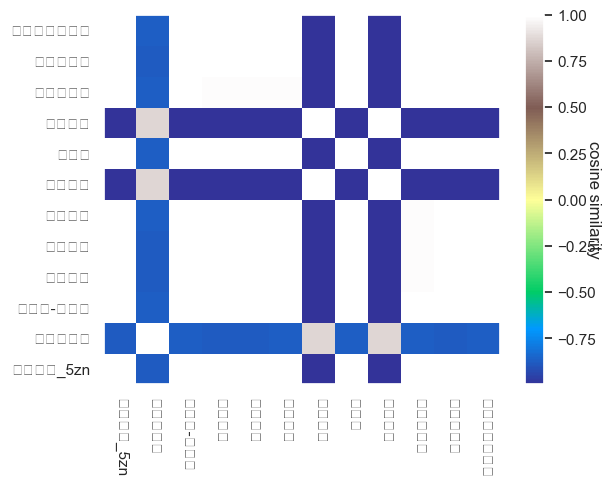

In [170]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [312]:
jul_topdf['text'][4]

'香港民众开始清扫垃圾~ 微博视频 \u200b\u200b\u200b很多香港百姓是清醒的~  微博视频 \u200b\u200b\u200b【視頻|香港工會聯會會（工聯會）15日到政府總部進行“反欺凌、反暴力”請願行動，要求保安局及警務處充分授權警隊嚴正執法，亦強烈要求特區政府必須加強警察的防暴裝備和支援。 香港中通社的秒拍视频 \u200b\u200b\u200b727元朗@香港警察 抓获暴乱份子“美国队长”  网页链接 \u200b深圳灣面朝香港🇨🇳紅旗飄飄 武力统一的秒拍视频 \u200b警察和速龙小队硬气起来了！抓住废青们，就脱口罩，各类废青失去面罩，瞬间失去战斗力！吓得面如土色！大快人心，港警威猛十分欠赞#香港警察##港澳办回应香港局势# \u200b\u200b\u200b'

## 5.3 Semantic Influence Networks based on noun-verb pairs
to see check if they are using the same noun-verb pairs


In [172]:
jul_topdf['tokenized_sents'] = jul_topdf['text'].apply(lambda x: [word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
jul_topdf['normalized_sents'] = jul_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [173]:
g = posCooccurrence(jul_topdf['normalized_sents'].sum(), 'NN', 'VV')

In [174]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [175]:
len(g.nodes)

554

In [176]:
len(g.edges)

0

In [177]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [178]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(jul_topdf['text'])


In [179]:
tweetVects_incidence.shape


(12, 681)

In [180]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [181]:
print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 693
Number of edges: 728
Average degree:   2.1010


In [182]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 12
Number of edges: 56
Average degree:   9.3333


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


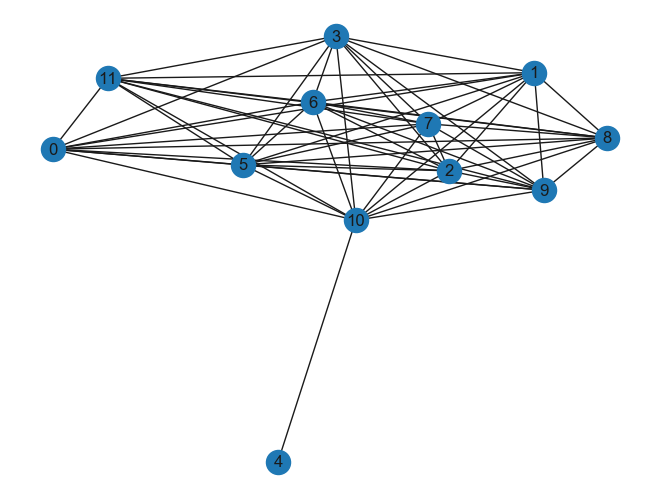

In [183]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

# 6. August Analysis

## 6.1 Word Count & Distribution to build Narrative

In [ ]:
#list the most used nouns

In [185]:
augdf['POS_sents'] = augdf['normalized_sents'].apply(lambda x: tag_sents_pos(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [186]:
augdf['POS_sents']

6544     [[(警署, NN), (外一, NN), (市民, NN), (因, IN), (支持, ...
6545     [[(墙头草, NNP), (随风倒, NNP), (里外不是人, NN), (首鼠两端, ...
6546     [[(在, IN), (油管, NN), (上面, NN), (看到, VV), (的, D...
6547     [[(驻港部队, NNP), (官宣, NN), (释放, VV), (维稳, NN), (...
6548     [[(香港, NNP), (警察, NN), (职方, NN), (协会, NN), (去,...
                               ...                        
18143    [[(新闻联播, NNP), (说, VV), (把, BB), (香港, NNP), (问...
18144    [[(新闻联播, NNP), (警告, VV), (香港, NNP), (暴力, NN), ...
18145    [[(香港, NNP), (金钟, NNP), (水, SFN), (炮车, NN), (到...
18146    [[(香港, NNP), (警方, NN), (情报, NN), (显示, VV), (激进...
18147    [[(有, VV), (恐怖分子, NNP), (持枪, VV), (正在, RB), (瞄...
Name: POS_sents, Length: 11604, dtype: object

In [313]:
countTarget = 'NN'
targetCounts = {}
for entry in augdf['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1

In [314]:
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)

In [315]:
sortedTargets[:30]

[('视频', 5848),
 ('全文', 5808),
 ('警方', 4082),
 ('警察', 3685),
 ('暴力', 3315),
 ('微博', 3297),
 ('示威者', 3169),
 ('\u200b', 2958),
 ('人', 2170),
 ('暴徒', 2036),
 ('等', 1791),
 ('记者', 1498),
 ('内地', 1329),
 ('国旗', 1302),
 ('新闻', 1301),
 ('秒', 1279),
 ('分子', 1218),
 ('警员', 1165),
 ('市民', 1134),
 ('今天', 1020),
 ('媒体', 931),
 ('集会', 929),
 ('活动', 926),
 ('社会', 925),
 ('机场', 911),
 ('问题', 910),
 ('国家', 880),
 ('示威', 837),
 ('航空', 813),
 ('今日', 787)]

In [316]:
nntoken = lucem_illud_2020.normalizeTokens(sortedTargets, lemma=False)

In [317]:
nntoken[:30]

['视频',
 '全文',
 '警方',
 '警察',
 '暴力',
 '微博',
 '示威者',
 '\\u200b',
 '人',
 '暴徒',
 '等',
 '记者',
 '内地',
 '国旗',
 '新闻',
 '秒',
 '分子',
 '警员',
 '市民',
 '今天',
 '媒体',
 '集会',
 '活动',
 '社会',
 '机场',
 '问题',
 '国家',
 '示威',
 '航空',
 '今日']

In [318]:


#check the context of the word

In [319]:
import nltk
import seaborn as sns #makes our plots look nicer
all_words = augdf['text'].to_list()

def listToString(s):  
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
token = listToString(all_words)

token = word_tokenize(token)
#token = clean(token, stopwords_chi)

In [320]:
aText = nltk.Text(token)

aIndex = nltk.text.ConcordanceIndex(aText) 

In [339]:
aIndex.print_concordance('机场', lines = 1500)

Displaying 911 of 911 matches:
才 会 感受 到 压力 收起 全文 这才 是 香港 有 的 样子 香港 国际 机场 发生 的 动人 一幕 香港 青少年 管弦乐团 玩 了 一把 乐器 快 闪 奏
 下 5 东方之珠 ​ 展开 全文 这才 是 香港 有 的 样子 香港 国际 机场 发生 的 动人 一幕 香港 青少年 管弦乐团 玩 了 一把 乐器 快 闪 奏
 还是 去 世界之窗 和 欢乐谷 游玩 或者 是 去 深圳 北坐 高铁 宝安 机场 坐飞机 或者 从 深圳 过 香港 都 是 坐地铁 最最 方便 地铁 都 是 
 还是 去 世界之窗 和 欢乐谷 游玩 或者 是 去 深圳 北坐 高铁 宝安 机场 坐飞机 或者 从 深圳 过 香港 都 是 坐地铁 最最 方便 地铁 都 是 
SEN 2 日 上午 GFriend 为 参加 海外 行程 通过 仁川 国际 机场 前往 中国香港 plmm 们 正向 你 走来 ~ ​ 特朗普 香港 是 中国
今午 一架 从 日本 大阪 飞往 香港 的 快运 班机 在 大阪 关西 国际 机场 准备 起飞前 机上 有 两名 乘客 香港 广东 与 空姐 发生争执 大阪 警
独 有 空姐 和 机师 在 港 铁 辱骂 老人 国泰 航空 工会 呼吁 港独 机场 集会 就是 上次 一个 老先生 被围 的 那天 香港机场 实施 出入 管制 
的 几个 估摸 着 明后天 会 乘 闹事 警力 都 集中 在 闹事 区域 逃 机场 码头 车站 啥 是 不 可能 的 但 香港 毕竟 是 港口 渔船 很多 上次
的 几个 估摸 着 明后天 会 乘 闹事 警力 都 集中 在 闹事 区域 逃 机场 码头 车站 啥 是 不 可能 的 但 香港 毕竟 是 港口 渔船 很多 上次
9 生日快乐 ☀ 金艺源 0819 生日快乐 视频 190802 香港 国际 机场 入境 新闻 视频 一则 资源 大 毛 微管 奶茶 招新 公告 💌 网页 链接
通 運輸業 總工會 香港 鐵路工 ​ 展开 全文 中国香港 游客 滞留 日本 机场 祖国 安排 飞机 全部 接 回 军武季 的 微博 视频 ​ 还 香港 安宁 
有心人士 利用 为了 不让 爱豆 关联 负面 社会 事件 请 不要 在 HK 机场 逗留 不要 与 他人 起 冲突 看到 冲突 不要 拍照 到达 机场 后 

In [338]:
aText.common_contexts(['机场'])

国际_发生 宝安_坐飞机 国际_前往 国际_准备 港独_集会 逃_码头 国际_入境 日本_祖国 hk_逗留 到达_后 珠海_坐 去_​
日本_时 国际_实际上 受阻_170 国际_可能 影响_正常 国际_部分 国际_至少 取消_快线


In [323]:
#check the distribution of the word

/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

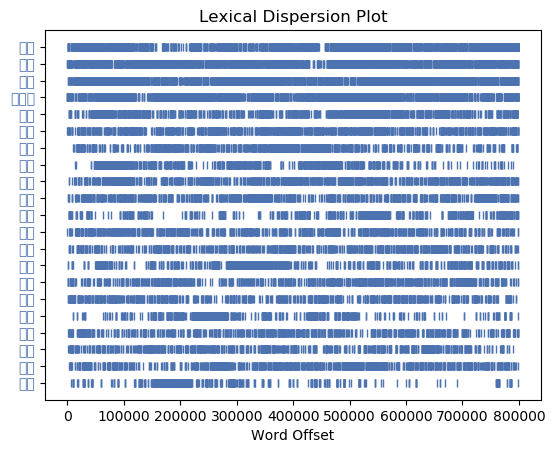

In [324]:
sns.reset_orig() 
aText.dispersion_plot([ 
 '警方',
 '警察',
 '暴力',
 '示威者',
 '暴徒',
 '记者',
 '内地',
 '国旗',
 '新闻',
 '分子',
 '警员',
 '市民',
 '媒体',
 '集会',
 '活动',
 '社会',
 '机场',
 '问题',
 '国家',
 '示威',
 '航空'])
sns.set() 


## 6.2 Top Contributor Similarity Test

In [204]:
#creating a database with only top 15 contributors

In [205]:
aug_topdf = augdf

In [206]:
aug_username = aug_topdf['name'].tolist()

aug_countedWords = wordCounter(aug_username)

In [207]:
aug_countedWords[:3]

,word,count
0,北京人不知道的北京事儿,4
1,韩东言,117
2,nobitatong,1


In [208]:
aug_topdf = aug_topdf.sort_values(by=['top_contributor'], ascending=False)
aug_topdf=aug_topdf.reset_index(drop=True)

In [209]:
aug_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,08/18/19,环球网,晚19 ：00，位于湾仔附近的过海轮渡排起了长队，一部分示威者选择早早打道回府。（赴香港特派...,34.0,1011.0,1045.0,"[晚, 19, 00, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长队...","[晚, 19, 00, 位于, 湾仔, 附近, 海轮, 渡排, 长队, 一部分, 示威者, ...","[[晚, 19, 00, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长...","[[晚, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长队, 一部分, ...",1,"[[(晚, NN), (位于, VV), (湾仔, NNP), (附近, NN), (的, ..."
1,08/26/19,环球时报,【香港警方：同事受到致命威胁，警枪是当时唯一最合适武力】针对在周六周日观塘和荃葵青游行示威又...,175.0,2086.0,2261.0,"[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, 武...","[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 当时, 唯一, 最合适, 武力, ...","[[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, ...","[[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, ...",1,"[[(香港, NNP), (警方, NN), (同事, NN), (受到, VV), (致命..."
2,08/09/19,环球时报,【台媒：金马奖遭抵制却像捡到枪 民进党夜郎自大无知到极点】继国家电影局暂停大陆影片和人员参加...,559.0,17316.0,17875.0,"[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知,...","[台媒, 金马奖, 遭, 抵制, 却, 捡, 枪, 民进党, 夜郎自大, 无知, 到极点, ...","[[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知...","[[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知...",1,"[[(台媒, NNP), (金马奖, NNP), (遭, VV), (抵制, NN), (却..."


In [210]:
for i in range (len(aug_topdf)):
    if aug_topdf['top_contributor'][i] == 0:
        print (i)
        break 

2047


In [211]:
aug_topdf = aug_topdf.drop(aug_topdf.index[295:])

In [212]:
aug_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,08/18/19,环球网,晚19 ：00，位于湾仔附近的过海轮渡排起了长队，一部分示威者选择早早打道回府。（赴香港特派...,34.0,1011.0,1045.0,"[晚, 19, 00, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长队...","[晚, 19, 00, 位于, 湾仔, 附近, 海轮, 渡排, 长队, 一部分, 示威者, ...","[[晚, 19, 00, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长...","[[晚, 位于, 湾仔, 附近, 的, 过, 海轮, 渡排, 起, 了, 长队, 一部分, ...",1,"[[(晚, NN), (位于, VV), (湾仔, NNP), (附近, NN), (的, ..."
1,08/26/19,环球时报,【香港警方：同事受到致命威胁，警枪是当时唯一最合适武力】针对在周六周日观塘和荃葵青游行示威又...,175.0,2086.0,2261.0,"[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, 武...","[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 当时, 唯一, 最合适, 武力, ...","[[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, ...","[[香港, 警方, 同事, 受到, 致命, 威胁, 警枪, 是, 当时, 唯一, 最合适, ...",1,"[[(香港, NNP), (警方, NN), (同事, NN), (受到, VV), (致命..."
2,08/09/19,环球时报,【台媒：金马奖遭抵制却像捡到枪 民进党夜郎自大无知到极点】继国家电影局暂停大陆影片和人员参加...,559.0,17316.0,17875.0,"[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知,...","[台媒, 金马奖, 遭, 抵制, 却, 捡, 枪, 民进党, 夜郎自大, 无知, 到极点, ...","[[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知...","[[台媒, 金马奖, 遭, 抵制, 却, 像, 捡, 到, 枪, 民进党, 夜郎自大, 无知...",1,"[[(台媒, NNP), (金马奖, NNP), (遭, VV), (抵制, NN), (却..."


In [213]:
aug_topdf = aug_topdf.sort_values(by=['name'], ascending=True)
aug_topdf=aug_topdf.reset_index(drop=True)

In [214]:
aug_topdf[:3]

,date,name,text,retweets,like,pop,tokenized_words,normalized_words,tokenized_sents,normalized_sents,top_contributor,POS_sents
0,08/25/19,上帝之鹰_5zn,#丈育笑集# 废Q表示：假如不买东江水，香港不会缺水，但广东省会破产 ​,263.0,13863.0,14126.0,"[丈育, 笑, 集, 废, Q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水, ...","[丈育, 笑, 集, 废, Q, 表示, 不买东, 江水, 香港, 不会, 缺水, 广东省,...","[[丈育, 笑, 集, 废, Q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水,...","[[丈育, 笑, 集, 废, q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水,...",1,"[[(丈育, NN), (笑, VV), (集, SFN), (废, VV), (q, NN..."
1,08/26/19,上帝之鹰_5zn,香港听众谈鸣枪事件：换了别的国家早就开枪了 上帝之鹰_5zn的微博视频 ​,79.0,1877.0,1956.0,"[香港, 听众, 谈, 鸣枪, 事件, 换, 了, 别的, 国家, 早就, 开枪, 了, 上...","[香港, 听众, 谈, 鸣枪, 事件, 换, 国家, 早就, 开枪, 上帝, 之鹰, 5zn...","[[香港, 听众, 谈, 鸣枪, 事件, 换, 了, 别的, 国家, 早就, 开枪, 了, ...","[[香港, 听众, 谈, 鸣枪, 事件, 换, 了, 别的, 国家, 早就, 开枪, 了, ...",1,"[[(香港, NNP), (听众, NN), (谈, VV), (鸣枪, NN), (事件,..."
2,08/09/19,上帝之鹰_5zn,正能量向：内地警察自发开展撑警活动，为香港同僚加油打气。 ​,88.0,2402.0,2490.0,"[正, 能量, 向, 内地, 警察, 自发, 开展, 撑警, 活动, 为, 香港, 同僚, ...","[正, 能量, 内地, 警察, 自发, 开展, 撑警, 活动, 香港, 同僚, 加油打气, ​]","[[正, 能量, 向, 内地, 警察, 自发, 开展, 撑警, 活动, 为, 香港, 同僚,...","[[正, 能量, 向, 内地, 警察, 自发, 开展, 撑警, 活动, 为, 香港, 同僚,...",1,"[[(正, RB), (能量, NN), (向, IN), (内地, NN), (警察, N..."


In [215]:
aug_username = aug_topdf['name'].tolist()
aug_countedWords = wordCounter(aug_username)
aug_countedWords

,word,count
0,上帝之鹰_5zn,10
1,中国新闻网,39
2,大公報-大公網,21
3,帝吧官微,6
4,李元芳星球,10
5,武力统一,11
6,热门表哥,13
7,环球时报,42
8,环球网,49
9,观察者网,24


In [216]:
aug_topdf = aug_topdf.drop(columns=['date','retweets','like','pop','tokenized_words','normalized_words','top_contributor','POS_sents'])


In [217]:
aug_topdf[:3]

,name,text,tokenized_sents,normalized_sents
0,上帝之鹰_5zn,#丈育笑集# 废Q表示：假如不买东江水，香港不会缺水，但广东省会破产 ​,"[[丈育, 笑, 集, 废, Q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水,...","[[丈育, 笑, 集, 废, q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水,..."
1,上帝之鹰_5zn,香港听众谈鸣枪事件：换了别的国家早就开枪了 上帝之鹰_5zn的微博视频 ​,"[[香港, 听众, 谈, 鸣枪, 事件, 换, 了, 别的, 国家, 早就, 开枪, 了, ...","[[香港, 听众, 谈, 鸣枪, 事件, 换, 了, 别的, 国家, 早就, 开枪, 了, ..."
2,上帝之鹰_5zn,正能量向：内地警察自发开展撑警活动，为香港同僚加油打气。 ​,"[[正, 能量, 向, 内地, 警察, 自发, 开展, 撑警, 活动, 为, 香港, 同僚,...","[[正, 能量, 向, 内地, 警察, 自发, 开展, 撑警, 活动, 为, 香港, 同僚,..."


In [218]:
aug_topdf = aug_topdf.groupby(['name'], as_index = False).agg({'text': ''.join})

In [219]:
aug_topdf

,name,text
0,上帝之鹰_5zn,#丈育笑集# 废Q表示：假如不买东江水，香港不会缺水，但广东省会破产 ​香港听众谈鸣枪事...
1,中国新闻网,【民航局：通过增加运力等保障内地与香港间旅客正常出行】据中国民用航空局网站消息，针对近期香港...
2,大公報-大公網,【市民：不再沉默 支持警察执法】一群爱国爱港市民今天（9日）中午自发到湾仔警察总部，向警察表...
3,帝吧官微,这么牛逼呢，捅伤了港警，港独废青还敢在连登上秀凶器，勇气可嘉，勇气可嘉。这些垃圾复读机早晚会...
4,李元芳星球,香港市民也忍不下去了。支持请 ​有图有真相 河运尸#香港示威者意图瘫痪机场道路无人响应##涉...
5,武力统一,这是三年前的视频，分析了美国发起颜色革命的十二个步骤，美国在香港的颜色革命策划多年，一系列的...
6,热门表哥,香港怪现象 ​终于看到水炮车出动了，希望能在这些废青身上试一试威力，把香港的这些污垢蛀虫全冲...
7,环球时报,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...
8,环球网,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...
9,观察者网,【马来西亚：不接纳香港“反修例示威者”居留申请】据路透社，近期香港居民申请马来西亚长期居留计...


In [220]:
aug_topdf['text'][4]

'香港市民也忍不下去了。支持请 \u200b有图有真相 河运尸#香港示威者意图瘫痪机场道路无人响应##涉嫌殴打付国豪的又抓一个# \u200b废青所到之处一片狼藉，港人该反抗了吧#香港警方首次出动水炮车##荃湾# 元芳八卦的微博视频 \u200b#葵芳# 废青北角待不下去了，跑葵芳了还有废青那把枪是美制M320榴弹发射器#尖沙咀# 隔壁小胡的微博视频 \u200b深水埗警署外:香港警察冒着大雨，驱散废青，捉了好几只，辛苦了天桥上拍的警察真帅#香港警方首次出动水炮车##荃湾# 元芳八卦的微博视频 \u200b#香港市民痛批激进示威者搞乱香港#有记者采访香港大叔，香港大叔质问:他们这也叫示威者啊？阻止走路？阻止工作？阻止民生？灵魂三连问把废青问懵逼了承认自己是。。。给大叔点赞 #市民遭袭击怒斥示威者香港之耻# #林郑月娥召开记者会# 元芳八卦的微博视频 \u200b沙咀道:完整视频来了十几个废青袭击警察，警察拔抢警告！最后被一群记者堵在了楼道里，质问为什么开q#香港警方首次出动水炮车##荃湾##香港警察遭围堵鸣枪示警#元芳八卦的微博视频 \u200b香港示威者为什么那么多？根本原因在这里#香港未满16岁学生冲击中被捕##林郑月娥表示对暴力行为零容忍##这还是你去过的那个香港吗# 元芳八卦的微博视频 \u200b香港警察被废青追着打，哪个国家地区的警察允许被这样挑衅？ 对废青的仁慈换来的是得寸进尺！废青所到之处一片狼藉，竟然还要谈话解决···#香港警方再次强调鸣枪示警行为合理#  #香港妇女界举办守护家园大集会# \u200b【央视采访希腊大叔：去寻找真相，这并不难】近日，在澳大利亚街头，一位希腊大叔怒怼香港激进示威者受到网友点赞。据了解，这位希腊大叔彼得很喜欢政治，也知道香港历史，看到西方媒体扭曲事实的报道，他很难过。他忠告年轻人：“如果你足够聪明的话，该去寻找真相，这并不难。” \u200b  展开全文,【央视采访希腊大叔：去寻找真相，这并不难】近日，在澳大利亚街头，一位希腊大叔怒怼香港激进示威者受到网友点赞。据了解，这位希腊大叔彼得很喜欢政治，也知道香港历史，看到西方媒体扭曲事实的报道，他很难过。他忠告年轻人：“如果你足够聪明的话，该去寻找真相，这并不难。”#香港18岁女孩画画写信撑警##阿sir以德报怨勇救示威女子##香港总警司表示保护香港是警察第一责任#via:

In [221]:
#tokenize and normalize

In [222]:
#tokenize words
aug_topdf['tokenized_words'] = aug_topdf['text'].apply(lambda x: word_tokenize(x))

In [223]:
aug_topdf['normalized_words'] = aug_topdf['tokenized_words'].apply(lambda x: clean(x, stopwords_chi))


In [224]:
aug_topdf

,name,text,tokenized_words,normalized_words
0,上帝之鹰_5zn,#丈育笑集# 废Q表示：假如不买东江水，香港不会缺水，但广东省会破产 ​香港听众谈鸣枪事...,"[丈育, 笑, 集, 废, Q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水, ...","[丈育, 笑, 集, 废, Q, 表示, 不买东, 江水, 香港, 不会, 缺水, 广东省,..."
1,中国新闻网,【民航局：通过增加运力等保障内地与香港间旅客正常出行】据中国民用航空局网站消息，针对近期香港...,"[民航局, 通过, 增加, 运力, 等, 保障, 内地, 与, 香港, 间, 旅客, 正常,...","[民航局, 增加, 运力, 保障, 内地, 香港, 间, 旅客, 正常, 出行, 中国, 民..."
2,大公報-大公網,【市民：不再沉默 支持警察执法】一群爱国爱港市民今天（9日）中午自发到湾仔警察总部，向警察表...,"[市民, 不再, 沉默, 支持, 警察, 执法, 一群, 爱国, 爱港, 市民, 今天, 9...","[市民, 不再, 沉默, 支持, 警察, 执法, 一群, 爱国, 爱港, 市民, 今天, 9..."
3,帝吧官微,这么牛逼呢，捅伤了港警，港独废青还敢在连登上秀凶器，勇气可嘉，勇气可嘉。这些垃圾复读机早晚会...,"[这么, 牛, 逼, 呢, 捅, 伤, 了, 港警, 港独, 废青, 还, 敢, 在, 连,...","[牛, 逼, 捅, 伤, 港警, 港独, 废青, 还, 敢, 登上, 秀, 凶器, 勇气可嘉..."
4,李元芳星球,香港市民也忍不下去了。支持请 ​有图有真相 河运尸#香港示威者意图瘫痪机场道路无人响应##涉...,"[香港市民, 也, 忍, 不, 下去, 了, 支持, 请, ​, 有图, 有, 真相, 河运...","[香港市民, 忍, 不, 下去, 支持, 请, ​, 有图, 真相, 河运, 尸, 香港, ..."
5,武力统一,这是三年前的视频，分析了美国发起颜色革命的十二个步骤，美国在香港的颜色革命策划多年，一系列的...,"[这是, 三年, 前, 的, 视频, 分析, 了, 美国, 发起, 颜色, 革命, 的, 十...","[这是, 三年, 前, 分析, 美国, 发起, 颜色, 革命, 十二个, 步骤, 美国, 香..."
6,热门表哥,香港怪现象 ​终于看到水炮车出动了，希望能在这些废青身上试一试威力，把香港的这些污垢蛀虫全冲...,"[香港, 怪现象, ​, 终于, 看到, 水, 炮车, 出动, 了, 希望, 能, 在, 这...","[香港, 怪现象, ​, 终于, 看到, 水, 炮车, 出动, 希望, 废青, 身上, 试一..."
7,环球时报,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...,"[我们, 做, 这, 报道, 是, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子...","[做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港,..."
8,环球网,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...,"[我们, 做, 这, 报道, 是, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子...","[做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港,..."
9,观察者网,【马来西亚：不接纳香港“反修例示威者”居留申请】据路透社，近期香港居民申请马来西亚长期居留计...,"[马来西亚, 不, 接纳, 香港, 反修, 例, 示威者, 居留, 申请, 据, 路透社, ...","[马来西亚, 不, 接纳, 香港, 反修, 例, 示威者, 居留, 申请, 路透社, 近期,..."


In [227]:
keywords = [ '警方',
 '警察',
 '暴力',
 '示威者',
 '暴徒',
 '记者',
 '内地',
 '国旗',
 '新闻',
 '分子',
 '警员',
 '市民',
 '媒体',
 '集会',
 '活动',
 '社会',
 '机场',
 '问题',
 '国家',
 '示威',
 '航空']

taggedDocs = []
for index, row in aug_topdf.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['name'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))


In [228]:
aug_topdf['TaggedAbstracts'] = taggedDocs


In [229]:
aug_topdf

,name,text,tokenized_words,normalized_words,TaggedAbstracts
0,上帝之鹰_5zn,#丈育笑集# 废Q表示：假如不买东江水，香港不会缺水，但广东省会破产 ​香港听众谈鸣枪事...,"[丈育, 笑, 集, 废, Q, 表示, 假如, 不买东, 江水, 香港, 不会, 缺水, ...","[丈育, 笑, 集, 废, Q, 表示, 不买东, 江水, 香港, 不会, 缺水, 广东省,...","([丈育, 笑, 集, 废, Q, 表示, 不买东, 江水, 香港, 不会, 缺水, 广东省..."
1,中国新闻网,【民航局：通过增加运力等保障内地与香港间旅客正常出行】据中国民用航空局网站消息，针对近期香港...,"[民航局, 通过, 增加, 运力, 等, 保障, 内地, 与, 香港, 间, 旅客, 正常,...","[民航局, 增加, 运力, 保障, 内地, 香港, 间, 旅客, 正常, 出行, 中国, 民...","([民航局, 增加, 运力, 保障, 内地, 香港, 间, 旅客, 正常, 出行, 中国, ..."
2,大公報-大公網,【市民：不再沉默 支持警察执法】一群爱国爱港市民今天（9日）中午自发到湾仔警察总部，向警察表...,"[市民, 不再, 沉默, 支持, 警察, 执法, 一群, 爱国, 爱港, 市民, 今天, 9...","[市民, 不再, 沉默, 支持, 警察, 执法, 一群, 爱国, 爱港, 市民, 今天, 9...","([市民, 不再, 沉默, 支持, 警察, 执法, 一群, 爱国, 爱港, 市民, 今天, ..."
3,帝吧官微,这么牛逼呢，捅伤了港警，港独废青还敢在连登上秀凶器，勇气可嘉，勇气可嘉。这些垃圾复读机早晚会...,"[这么, 牛, 逼, 呢, 捅, 伤, 了, 港警, 港独, 废青, 还, 敢, 在, 连,...","[牛, 逼, 捅, 伤, 港警, 港独, 废青, 还, 敢, 登上, 秀, 凶器, 勇气可嘉...","([牛, 逼, 捅, 伤, 港警, 港独, 废青, 还, 敢, 登上, 秀, 凶器, 勇气可..."
4,李元芳星球,香港市民也忍不下去了。支持请 ​有图有真相 河运尸#香港示威者意图瘫痪机场道路无人响应##涉...,"[香港市民, 也, 忍, 不, 下去, 了, 支持, 请, ​, 有图, 有, 真相, 河运...","[香港市民, 忍, 不, 下去, 支持, 请, ​, 有图, 真相, 河运, 尸, 香港, ...","([香港市民, 忍, 不, 下去, 支持, 请, ​, 有图, 真相, 河运, 尸, 香港,..."
5,武力统一,这是三年前的视频，分析了美国发起颜色革命的十二个步骤，美国在香港的颜色革命策划多年，一系列的...,"[这是, 三年, 前, 的, 视频, 分析, 了, 美国, 发起, 颜色, 革命, 的, 十...","[这是, 三年, 前, 分析, 美国, 发起, 颜色, 革命, 十二个, 步骤, 美国, 香...","([这是, 三年, 前, 分析, 美国, 发起, 颜色, 革命, 十二个, 步骤, 美国, ..."
6,热门表哥,香港怪现象 ​终于看到水炮车出动了，希望能在这些废青身上试一试威力，把香港的这些污垢蛀虫全冲...,"[香港, 怪现象, ​, 终于, 看到, 水, 炮车, 出动, 了, 希望, 能, 在, 这...","[香港, 怪现象, ​, 终于, 看到, 水, 炮车, 出动, 希望, 废青, 身上, 试一...","([香港, 怪现象, ​, 终于, 看到, 水, 炮车, 出动, 希望, 废青, 身上, 试..."
7,环球时报,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...,"[我们, 做, 这, 报道, 是, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子...","[做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港,...","([做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港..."
8,环球网,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山...,"[我们, 做, 这, 报道, 是, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子...","[做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港,...","([做, 报道, 想, 证明, 香港, 很多, 人, 没有, 忘记, 狮子山, 精神, 香港..."
9,观察者网,【马来西亚：不接纳香港“反修例示威者”居留申请】据路透社，近期香港居民申请马来西亚长期居留计...,"[马来西亚, 不, 接纳, 香港, 反修, 例, 示威者, 居留, 申请, 据, 路透社, ...","[马来西亚, 不, 接纳, 香港, 反修, 例, 示威者, 居留, 申请, 路透社, 近期,...","([马来西亚, 不, 接纳, 香港, 反修, 例, 示威者, 居留, 申请, 路透社, 近期..."


In [230]:
aug_topdf['text'][8]

'【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山。“香港精神”常有另外一个指代——“狮子山精神”。香港人说，“狮子山精神”是认真工作、努力打拼，是迎接挑战、逆境自强，是开拓进取、灵活应变。然而，从2014年非法“占中”开始，狮子山这座香港人的 \u200b  展开全文,【我们做这报道，是想证明，香港很多人没有忘记“狮子山精神”】香港地标之一是高495米的狮子山。“香港精神”常有另外一个指代——“狮子山精神”。香港人说，“狮子山精神”是认真工作、努力打拼，是迎接挑战、逆境自强，是开拓进取、灵活应变。然而，从2014年非法“占中”开始，狮子山这座香港人的精神高地，就常被一些激进示威者利用。21日早8时许，香港警方接获报案，位于九龙的狮子山上挂有一幅约2米乘25米的横幅，上面写有煽动性标语，随后消防人员到场拆除。然而，真正的“狮子山精神”没有被香港人忘记。环球时报-环球网记者专门登上狮子山，并采访各行各业的香港人，听他们讲述自己的故事和对香港年轻一代的担忧，希望香港人能“放开彼此心中矛盾，理想一起去追”。全文：我们做这报道，是想证明，香港很多人没有忘记“狮子山精神” #狮子山精神# 环球网的微博视频 收起全文【哦，原来向警察认错悔过了。】刚刚，西藏自治区日喀则市定日县公安就此事在其官方微信公众号“定日公安”上发布警情通报，称2019年8月23日8时许，1名香港男子张某某在本地珠峰大本营手持一张印有“光复香港”等字样A4纸进行拍照时，被其他游客发现劝阻并报警。公安机关依法对其进行了警告。警情通 \u200b  展开全文,【哦，原来向警察认错悔过了。】刚刚，西藏自治区日喀则市定日县公安就此事在其官方微信公众号“定日公安”上发布警情通报，称2019年8月23日8时许，1名香港男子张某某在本地珠峰大本营手持一张印有“光复香港”等字样A4纸进行拍照时，被其他游客发现劝阻并报警。公安机关依法对其进行了警告。警情通报还称，张某某承认错误，表示将遵守内地法律，不再从事类似违法活动，具结悔过后被释放。以下为警情通报全文：2019年8月23日8时许,1名香港男子张某某在本地珠峰大本营手持一张印有“光复香港”等字样A4纸进行拍照时,被其他游客发现劝阻并报警。经审查,该男子行为违反了《治安管理处罚法》有关规定,公安机关依法对其进行了警告。张某某承认错

In [231]:
topD2V = gensim.models.doc2vec.Doc2Vec(aug_topdf['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [232]:
topD2V.docvecs[10]


array([-0.10574421, -0.48553905, -0.4017365 ,  0.4070337 , -0.08751512,
       -0.13790242,  0.1340994 , -0.10834196, -0.5532049 ,  0.58775526,
       -0.11246629, -0.03350569,  0.17853415,  0.07818411, -0.16352963,
        0.1847359 ,  0.24026504, -0.00156277, -0.6978089 , -0.33849847,
        0.59249705, -0.32173955, -0.26789087, -0.3610737 , -0.5445464 ,
       -0.0402245 ,  0.38551718,  0.35754573, -0.3789579 , -0.43073654,
        0.50869495,  0.00273819,  0.7210233 ,  0.29389223,  0.5370016 ,
        0.0145478 ,  0.07981895, -0.04060349, -0.09188283, -0.08094455,
       -0.50585276, -0.5632677 ,  0.0302538 , -0.6081524 , -0.13924576,
        0.16280165,  0.9498809 ,  0.30389127, -0.14158118, -0.06903573,
        0.60925585,  0.21787272,  0.09953109,  0.5909477 ,  0.15037592,
        0.25367835,  0.15631934, -0.4811672 , -0.08909679, -0.21709238,
       -0.19089586, -0.00826455,  0.05764088, -0.32551968,  0.05201301,
        0.15777975,  0.03139476, -0.06300616,  0.45996258,  0.39

In [233]:
targetDocs = aug_topdf['name']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = topD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, topD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

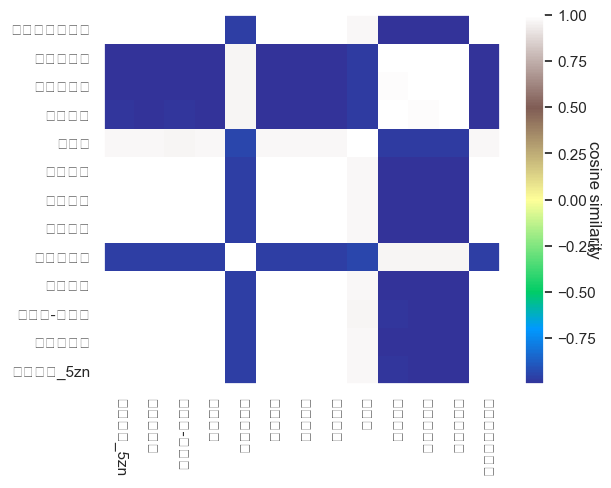

In [236]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [370]:
aug_topdf['text'][10]

'【#香港示威者意图瘫痪机场道路无人响应#】据报道，香港机场多次被非法示威者堵塞，导致运作完全瘫痪，虽然机管局申请延长临时禁制令获批，但仍有人发起所谓“和你塞”行动，煽动市民24日使用公共交通工具不断来往机场，试图瘫痪进出机场的道路。但响应的人数极少，交通未见堵塞。有旅客指出，需要提前 \u200b  展开全文,【#香港示威者意图瘫痪机场道路无人响应#】据报道，香港机场多次被非法示威者堵塞，导致运作完全瘫痪，虽然机管局申请延长临时禁制令获批，但仍有人发起所谓“和你塞”行动，煽动市民24日使用公共交通工具不断来往机场，试图瘫痪进出机场的道路。但响应的人数极少，交通未见堵塞。有旅客指出，需要提前多个小时到机场，令行程受影响，并批评发起所谓“不合作运动”者十分自私。@中国新闻网 中新视频的秒拍视频 收起全文【香港警方回应派卧底：警方行动与抓捕毒贩无异】12日，香港警务处副处长邓炳强在记者会上就警员的卧底活动作出了强有力的回应：“核心暴力示威者会使用致命武器，我们的行动与抓捕毒贩无异。”@微丢 微丢的秒拍视频 \u200b【#外国女游客斥乱港分子乱扔垃圾#：最起码应该捡起自己的垃圾！】23日晚，示威者在香港弥敦道附近示威，一名外国女游客提着一袋垃圾走近沟通。她说：“你们这些人站满这条街，最起码应该知道捡起自己的垃圾！”她一路沿着弥敦道前行，将示威者脚下的水瓶、纸巾、口罩纷纷捡起。N视频的微博视频 \u200b【怒怼激进示威者的希腊大叔：去寻找真相，这并不难】近日，在澳大利亚街头，一位希腊大叔怒怼香港激进示威者受到网友点赞。这位希腊大叔彼得喜欢政治，也知道香港历史，看到西方媒体扭曲事实，他很难过。他忠告年轻人：“如果你足够聪明，该去寻找真相，这并不难”。央视新闻的秒拍视频 \u200b【#新闻联播评香港恐怖暴行#：天若欲其亡，必先令其狂！！】暴力乱港分子这种严重威胁人身安全的极端暴力行径无异于公然谋杀，已明显带有恐怖主义的色彩，简直到了丧心病狂的地步。天若欲其亡，必先令其狂。那些乱港分子是历史洪流中的一股污泥浊水，必将被涤荡干净。对此，我们有足够的信心和能力。 \u200b  展开全文【民航局向香港国泰航空发出重大航空安全风险警示】8月9日，针对香港国泰航空近期在多起事件中暴露出的安全风险及隐患，民航局向香港国泰航空发出重大航空安全风险警示。近期，香港国泰航空先后发生飞行人员

## 6.3 Semantic Influence Networks based on noun-verb pairs¶
to see check if they are using the same noun-verb pairs

In [238]:
aug_topdf['tokenized_sents'] = aug_topdf['text'].apply(lambda x: [word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
aug_topdf['normalized_sents'] = aug_topdf['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [239]:
g = posCooccurrence(aug_topdf['normalized_sents'].sum(), 'NN', 'VV')

In [240]:
g.remove_edges_from([(n1,n2) for n1,n2,d in g.edges(data = True) if g.nodes[n1]['bipartite'] == g.nodes[n2]['bipartite']])

In [241]:
len(g.nodes)

627

In [242]:
len(g.edges)

0

In [243]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [244]:
#2-mode network
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized
import sklearn.feature_extraction

tweet_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
tweetVects_incidence = tweet_Vectorizer.fit_transform(aug_topdf['text'])


In [245]:
tweetVects_incidence.shape


(13, 754)

In [246]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((tweet_Vectorizer.get_feature_names()[i] for i in range(tweetVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(tweetVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, tweet_Vectorizer.get_feature_names()[w], {'weight' : tweetVects_incidence[d, w]}) for d, w in zip(*tweetVects_incidence.nonzero())))

In [247]:
print(nx.info(g_2mode))


Name: 
Type: Graph
Number of nodes: 767
Number of edges: 813
Average degree:   2.1199


In [248]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono


gDoc = contractNetwork(g_2mode, 'doc')

print(nx.info(gDoc))


Name: 
Type: Graph
Number of nodes: 13
Number of edges: 78
Average degree:  12.0000


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


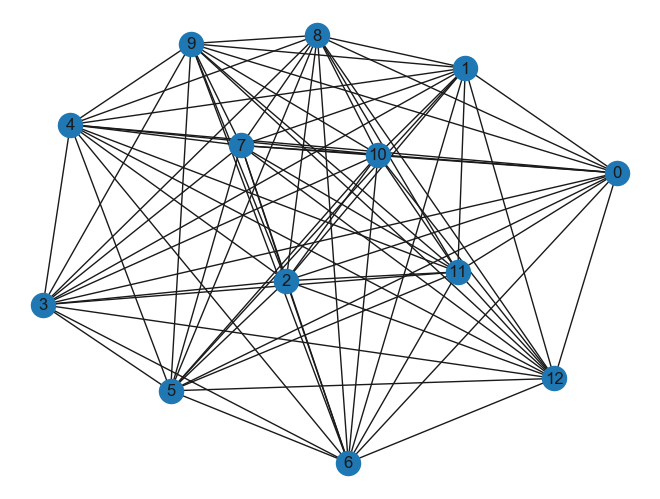

In [249]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [376]:
aug_topdf['text'][6]

'香港怪现象 \u200b终于看到水炮车出动了，希望能在这些废青身上试一试威力，把香港的这些污垢蛀虫全冲进粪坑里。关注@热门表哥 观看更多热门经典视频 热门表哥的微博视频 \u200b这群智障港独废青太会做梦了，真以为美国无所不能啊！别人是害怕外国势力介入，这群废青还想着美国派兵到香港来保护他们，看着他们在美国各大网站填写其诉求，看着很智障，诉求智障，行为更是智障，脑子是个好东西，可惜他们没有。 \u200b这是三年前的视频，分析了美国发起颜色革命的十二个步骤，美国在香港的颜色革命策划多年，一系列的抗议皆是其“杰作”，今天在香港发生的暴乱也是美国在香港发起颜色革命重要的一环，乌克兰当初也是如此。关注@热门表哥 观看更多热门经典视频 热门表哥的微博视频 \u200b在香港一事上，让大家看清了外媒的丑恶，看清了他们的双重标准，说出真相的人，外媒想方设法会让其闭嘴，抹黑香港和中国内地的都会被各种推荐。 \u200b在外网，你越来越难看到香港事件的真相，因为媒体统一口径是香港“市民”的诉求被拒和警察“殴打”示威“群众”。只要跟中国有关的事，在外媒那里几乎都是一边倒的与中国是对立方。有人说我是不是被国内媒体洗脑了，拜托，我看的都是外网且是黑媒体现场直播，虽然黑媒体总是把镜头对准香港警察，但仍然 \u200b  展开全文,在外网，你越来越难看到香港事件的真相，因为媒体统一口径是香港“市民”的诉求被拒和警察“殴打”示威“群众”。只要跟中国有关的事，在外媒那里几乎都是一边倒的与中国是对立方。有人说我是不是被国内媒体洗脑了，拜托，我看的都是外网且是黑媒体现场直播，虽然黑媒体总是把镜头对准香港警察，但仍然能清楚的让大家了解事情的真相。 收起全文美国频频干涉中国香港事务，在背后各种组织策划煽动，让俄罗斯都看不下去，直接批评美国的无耻。 \u200b1960年的香港影像，这一年也是香港发展的转折点。关注@热门表哥 观看更多热门经典视频 热门表哥的微博视频 \u200b香港警方这是要改变策略了吗？ \u200b贺一诚当选澳门第五任行政长官，也是澳门第三位特首(前两任皆任两届)。香港在搞暴乱，澳门在搞发展，这就是区别。关注@热门表哥 观看更多热门经典视频 热门表哥的微博视频 \u200b英国殖民香港时，香港人没有民主和自由，香港人很听话，你敢暴动，直接不给你好果子吃；香港回归后，有了民主自由，